# IST 718 Laboratory Exercise - 1

Created by: Victoria Haley

Date: 1/19/2024

## Research question: How can we recommend the best salary (totalpay or schoolpay – your choice) for our next head football coach?

In addition to using the provided Coaches data, this report will also include:

- 2023 College Football Standings provided by https://www.sports-reference.com/cfb/years/2023-standings.html
- Social Media Big Data and NIL Value for College Football Players provided by Jack McLeod https://www.samford.edu/sports-analytics/fans/2022/Social-Media-Big-Data-and-NIL-Value-for-College-Football-Players

In [199]:
# Loading necessary libraries
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import statsmodels.api as st
from tabulate import tabulate

## Step 1: Obtain data and understand data structures and data elements

In [200]:
#Function to open/read the file and create dataframe and prints information of DF
def get_data(file):
    data = pd.read_csv(file)
    df = pd.DataFrame(data.values, columns=data.columns, index=data.index)
    return df
   
#Funtion to analyze the data
def analyze_data(data):
    stats = data.describe(include='all')
    print('Descriptive Statistics')
    print(stats)
    nulls = data.isnull().sum()
    print()
    print('Any null values?')
    print(nulls)
    dups = data.duplicated().values.any()
    print()
    print('Any duplicates?')
    print(dups)
    print()
    print('First 5 Rows of Data Frame:')
    print(data.head())

In [201]:
#Next, use function to open coaches data file
file = 'coaches_modify.csv'
coaches_df = get_data(file)

#Next: Exploring the data to discover what we're working with, as well as any potential things that need to be
#cleaned up.

analyze_data(coaches_df)

Descriptive Statistics
           School Conf         Coach  NCAAFBREV16   MedianConfSal  SchoolPay  \
count         118  118           118          99.0            118      118.0   
unique        118   11           118          99.0              9       98.0   
top     Air Force  SEC  Troy Calhoun    59577780.0        2458033        0.0   
freq            1   14             1           1.0             26        5.0   

           TotalPay  BonusMax  PayPlusBonus  StadSize  ...   GSRank   \
count    118.000000     118.0         118.0       118  ...       118   
unique    98.000000      78.0         108.0       103  ...        43   
top     1797.637391       0.0           0.0     30000  ...        40   
freq       5.000000      22.0           4.0         6  ...        11   

         Combo Rank    TrueRank       W      L   Ratio   OffenceScore  \
count            118         118  107.0  107.0    107.0        107.00   
unique            75          97   14.0   11.0     20.0        104.00

In [202]:
# Next, use function to open 2023 Standings data file
file = 'sportsref_download.csv'
standings_df = get_data(file)

#Next: Exploring the data to discover what we're working with, as well as any potential things that need to be
#cleaned up.

analyze_data(standings_df)

Descriptive Statistics
           Rk         School Conf  total_W  total_L  total_Pct  conf_W  \
count   133.0            133  133    133.0    133.0    133.000   129.0   
unique  133.0            133   15     15.0     12.0     22.000    11.0   
top       1.0  Florida State  ACC      7.0      7.0      0.538     3.0   
freq      1.0              1   14     16.0     25.0     16.000    27.0   

        conf_L  conf_Pct  OffPPG  DefPPG     SRS     SOS  APCurr  APPre  \
count    129.0   129.000   133.0   133.0  133.00  133.00    25.0   25.0   
unique     9.0    20.000   102.0    95.0  129.00  131.00    24.0   25.0   
top        5.0     0.375    23.2    28.6    7.41    2.67     6.0    8.0   
freq      23.0    20.000     5.0     4.0    2.00    2.00     2.0    1.0   

        APHigh Unnamed: 16  
count     44.0           0  
unique    19.0           0  
top        9.0         NaN  
freq       5.0         NaN  

Any null values?
Rk               1
School           1
Conf             1
total_W   

In [203]:
#Next, use function to open the NIL data file
file = 'CFB-NIL-Master-Results-Document.csv'
NIL_df = get_data(file)

#Next: Exploring the data to discover what we're working with, as well as any potential things that need to be
#cleaned up.

analyze_data(NIL_df)

Descriptive Statistics
                     Name  Overall  Overall (x5)  Football Fans  \
count                 357    352.0         352.0          352.0   
unique                356     12.0          12.0           19.0   
top     Jarrett Patterson      0.1           0.5            0.2   
freq                    2    145.0         145.0           69.0   

        American Sports  College Sports  College Football Fans  Basketball  \
count             352.0           352.0                  352.0       351.0   
unique              5.0             4.0                   39.0        24.0   
top                 0.0             0.0                    0.2         0.1   
freq              282.0           285.0                   57.0        81.0   

        NFL Fans  Republicans  Pop Culture  Final Raw Relevance #   School  \
count      352.0        352.0        352.0                  352.0      352   
unique      13.0         20.0          4.0                   82.0       70   
top          0.1

Given the insights provided, we can see that:
Coaches Data:
- There are 118 total entries in int64 format in the dataset with 118 unique schools in 11 unique conferences. 
- The most frequently occuring conference is the South Eastern Conference (SEC)
- There are a few nulls, mostly in the NCAAFBREV16 column. Seeing that the last 7 columns deal with records, these will be dropped as this report will use the updated 2023 standings data.

2023 Standings Data:
- There are 133 entries (schools) in the dataset, although the last row is blank.
- The 'Conf' column has 15 unique values, with 'ACC' being the most frequent.
- The columns 'APCurr,' 'APPre,' 'APHigh,' and 'Unnamed: 16' have a significant number of missing values, however 'Unnamed: 16' appears to be a blank column and will need to be dropped.

NIL Data:
- There are 357 entries in the dataset, however it appears as though Jarrett Patterson appears twice.
- The dataset has null values and duplicate entries.

As such, missing and duplicate values will need to be handled, non-football entries and other unnecessary columns will need to be dropped, and categorical values will need to be transformed from int64 to factor.

## Step 2: Scrub data using scripting methods, to include debugging, for data manipulation

In [204]:
#Based on the information above, the following transformations are needed so that the data can be manipulated

# Transforming categorical variables from int64 to factor and quantitative variables from object to numeric

# coaches data
cols_to_convert = ['School', 'Conf', 'Coach']
# Convert selected columns to category type
coaches_df[cols_to_convert] = coaches_df[cols_to_convert].astype('category')

# Transforming quantitative data into numeric format
cols_to_convert = coaches_df.columns[3:]
# Convert the selected columns to numeric
coaches_df[cols_to_convert] = coaches_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')


# Verify the changes
print('Coaches Data Types:')
print(coaches_df.dtypes)
print()


# standings data
cols_to_convert = ['Rk', 'School', 'Conf']
# Convert selected columns to category type
standings_df[cols_to_convert] = standings_df[cols_to_convert].astype('category')

# Transforming quantitative data into numeric format
cols_to_convert = standings_df.columns[3:]
# Convert the selected columns to numeric
standings_df[cols_to_convert] = standings_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Verify the changes
print('Standings Data Types:')
print(standings_df.dtypes)
print()

# NIL data
cols_to_convert = ['Name', 'School', 'Position', 'Classification']
# Convert selected columns to category type
NIL_df[cols_to_convert] = NIL_df[cols_to_convert].astype('category')
# Transforming quantitative data into numeric format isn't needed here since we are only going to keep Names
# Verify the changes
print('NIL Data Types:')
print(NIL_df.dtypes)

Coaches Data Types:
School                     category
Conf                       category
Coach                      category
NCAAFBREV16                 float64
MedianConfSal                 int64
SchoolPay                   float64
TotalPay                    float64
BonusMax                    float64
PayPlusBonus                float64
StadSize                      int64
 Graduation Rate (GSR)        int64
 Seat Rank                    int64
 GSRank                       int64
 Combo Rank                   int64
 TrueRank                     int64
W                           float64
L                           float64
 Ratio                      float64
OffenceScore                float64
Defense Score               float64
Score                       float64
PointsPerGame               float64
dtype: object

Standings Data Types:
Rk             category
School         category
Conf           category
total_W         float64
total_L         float64
total_Pct       float64
conf_W 

In [205]:
# Coaches data

'''For the coaches data, the null values in the NCAAFBREV16 column are likely due to schools not reporting
their revenue. For the purposes of this report, the values will be changed to 0 '''

# Replace nulls with 0
coaches_df['NCAAFBREV16 '] = coaches_df['NCAAFBREV16 '].fillna(0)

#The last 7 columns that deal with records will be dropped
coaches_df.drop(coaches_df.columns[15:24], axis=1, inplace=True)

# Print the DataFrame to verify changes
print(coaches_df)

                School      Conf              Coach  NCAAFBREV16   \
0            Air Force  Mt. West       Troy Calhoun    59577780.0   
1                Akron       MAC       Terry Bowden    35331217.0   
2              Alabama       SEC         Nick Saban   174307419.0   
3    Appalachian State  Sun Belt  Scott Satterfield    35058621.0   
4              Arizona    Pac-12       Kevin Sumlin    90976758.0   
..                 ...       ...                ...           ...   
113   Washington State    Pac-12         Mike Leach    64294520.0   
114      West Virginia    Big 12     Dana Holgorsen   110565870.0   
115   Western Michigan       MAC         Tim Lester    38516531.0   
116          Wisconsin   Big Ten        Paul Chryst   143420668.0   
117            Wyoming  Mt. West         Craig Bohl    40372222.0   

     MedianConfSal    SchoolPay     TotalPay     BonusMax  PayPlusBonus  \
0           879288   454.545455   454.545455   126.861839    454.545455   
1           492413   

In [206]:
# Checking to make sure nulls have been handled
nulls = coaches_df.isnull().sum()
print(nulls)

School                     0
Conf                       0
Coach                      0
NCAAFBREV16                0
MedianConfSal              0
SchoolPay                  0
TotalPay                   0
BonusMax                   0
PayPlusBonus               0
StadSize                   0
 Graduation Rate (GSR)     0
 Seat Rank                 0
 GSRank                    0
 Combo Rank                0
 TrueRank                  0
dtype: int64


In [207]:
# Standings Data

# First, drop unnecessary columns
standings_df.drop(columns=['Unnamed: 16','Conf', 'Rk'], inplace=True)
    # Conference name isn't needed here because it will be merged with all data frames later on
    # Rk isn't needed as this is just an index and not an actual rank
    
# Next, drop the blank row 133
standings_df.drop(index=133, inplace=True)

# For the blanks in the AP Poll columns, we will just place '0' to indicate schools that were unranked.
standings_df[['APCurr', 'APPre', 'APHigh']] = standings_df[['APCurr', 'APPre', 'APHigh']].fillna("0")

# Print the DataFrame to verify changes
print(standings_df)

                   School  total_W  total_L  total_Pct  conf_W  conf_L  \
0           Florida State     13.0      1.0      0.929     9.0     0.0   
1              Louisville     10.0      4.0      0.714     7.0     2.0   
2    North Carolina State      9.0      4.0      0.692     6.0     2.0   
3            Georgia Tech      7.0      6.0      0.538     5.0     3.0   
4           Virginia Tech      7.0      6.0      0.538     5.0     3.0   
..                    ...      ...      ...        ...     ...     ...   
128         South Alabama      7.0      6.0      0.538     4.0     4.0   
129        Arkansas State      6.0      7.0      0.462     4.0     4.0   
130             Louisiana      6.0      7.0      0.462     3.0     5.0   
131  Southern Mississippi      3.0      9.0      0.250     2.0     6.0   
132      Louisiana-Monroe      2.0     10.0      0.167     0.0     8.0   

     conf_Pct  OffPPG  DefPPG    SRS   SOS APCurr APPre APHigh  
0       1.000    34.6    19.3  16.51  2.94    

In [208]:
# NIL Data

# First, we need to take a look at the duplicated entry
duplicate_names = NIL_df[NIL_df.duplicated(subset=['Name'], keep=False)]

# Print the entries with the same name
print("Entries with the Same Name:")
print(duplicate_names)

Entries with the Same Name:
                  Name Overall Overall (x5) Football Fans American Sports  \
270  Jarrett Patterson     0.1          0.5           0.3             0.0   
289  Jarrett Patterson     0.1          0.5           0.3             0.0   
352                NaN     NaN          NaN           NaN             NaN   
353                NaN     NaN          NaN           NaN             NaN   
354                NaN     NaN          NaN           NaN             NaN   
355                NaN     NaN          NaN           NaN             NaN   
356                NaN     NaN          NaN           NaN             NaN   
357                NaN     NaN          NaN           NaN             NaN   
358                NaN     NaN          NaN           NaN             NaN   
359                NaN     NaN          NaN           NaN             NaN   
360                NaN     NaN          NaN           NaN             NaN   
361                NaN     NaN          NaN     

In [209]:
'''It appears as though the duplicated entry for Jarrett Patterson is due to him having data for his Junior
and Senior year. For the purpose of this report, we'll aggregate the data into 1 entry. Because the data is
social media sentiment, the means of the observations will be taken.'''

NIL_df = NIL_df.groupby('Name').agg({'Name': 'first','Overall': 'mean','Overall (x5)': 'mean',
                                     'Football Fans': 'mean','American Sports': 'mean',
                                     'College Sports': 'mean', 'College Football Fans': 'mean',
                                    'Basketball': 'mean', 'NFL Fans': 'mean','Republicans': 'mean',
                                    'Pop Culture': 'mean', 'Final Raw Relevance #': 'mean',
                                    'School': 'first', 'Position': 'first','Classification': 'last'})

# Besides that, there are nulls in the data frame, however we will leave them be as we will only use this data
# for counts of NIL athletes per school.

In [210]:
'''Next, we will merge all of the data frames so that we can move on to the Explore step
After looking at our data frames, joining the data frames by School will be our best bet. However, only the
coaches, standings, and NIL data frames have a 'School' column so we will need to join the 
graduation rate data in a different line. Due to the data frames having different school naming conventions, 
nick names, or occasional misspellings, we will first need to map the school names so that the data will match
up nicely.'''

school_name_mapping = {
    'Air Force': ['AF', 'U.S. Air Force Academy'],
    'Akron': [],
    'Alabama': ['Bama', 'Alabama ', 'University of Alabama'],
    'Alabama at Birmingham': ['UAB', 'Alabama at Birmingham'],
    'Appalachian State': ['App State', 'Appalachian State University'],
    'Arizona': ['University of Arizona'],
    'Arizona State': ['ASU', 'Arizona State University'],
    'Arkansas': ['Ark', 'University of Arkansas, Fayetteville'],
    'Arkansas State': ['A-State', 'Arkansas State University'],
    'Army': ['U.S. Military Academy'],
    'Auburn': ['Auburn University'],
    'Ball State': ['Ball State University'],
    'Baylor': ['Baylor University'],
    'Boise State': ['Boise State University'],
    'Boston College': ['BC'],
    'Bowling Green': ['Bowling Green State University'],
    'Brigham Young': ['BYU', 'Brigham Young University'],
    'Buffalo': ['University at Buffalo, the State University of New York'],
    'California': ['Cal', 'University of California, Berkeley'],
    'Central Florida': ['UCF', 'University of Central Florida'],
    'Central Michigan': ['CMU', 'Central Michigan University'],
    'Charlotte': ['UNC Charlotte', 'University of North Carolina, Charlotte'],
    'Cincinnati': ['Cincy', 'University of Cincinnati'],
    'Clemson': ['Clemson University'],
    'Coastal Carolina': ['CCU', 'Coastal Carolina University', 'Coastal Carolina Chanticleers'],
    'Colorado': ['CU', 'University of Colorado, Boulder'],
    'Colorado State': ['CSU', 'Colorado State University'],
    'Connecticut': ['UConn', 'University of Connecticut'],
    'Duke': ['Duke University',],
    'East Carolina': ['ECU', 'East Carolina University'],
    'Eastern Michigan': ['EMU'],
    'Florida': ['UF', 'UFL', 'University of Florida'],
    'Florida Atlantic': ['FAU', 'Florida Atlantic University'],
    'Florida International': ['FIU', 'Florida International University', 'Florida International'],
    'Florida State': ['FSU', 'Florida State University'],
    'Fresno State': ['California State University, Fresno'],
    'Georgia': ['UGA', 'University of Georgia'],
    'Georgia Southern': ['Ga Southern', 'Georgia Southern University'],
    'Georgia State': ['Ga State', 'Georgia State University'],
    'Georgia Tech': ['GT', 'Georgia Institute of Technology'],
    'Hawaii': ['University of Hawaii, Manoa'],
    'Houston': ['University of Houston'],
    'Illinois': ['UIUC', 'University of Illinois, Champaign'],
    'Indiana': ['IU','Indiana University, Bloomington'],
    'Iowa': ['University of Iowa'],
    'Iowa State': ['ISU', 'Iowa State University'],
    'Kansas': ['KU', 'University of Kansas'],
    'Kansas State': ['KSU', 'K-State', 'Kansas State University'],
    'Kent State': ['Kent State University'],
    'Kentucky': ['UK', 'University of Kentucky'],
    'Liberty': ['Liberty University', 'Liberty Flames', 'Liberty'],
    'Louisiana Tech': ['La Tech', 'Louisiana Tech University', 'Louisiana Tech'],
    'Louisiana-Lafayette': ['ULL', 'ULLafayette','Louisiana', 'University of Louisiana at Lafayette'],
    'Louisiana-Monroe': ['ULM', 'University of Louisiana at Monroe'],
    'Louisville': ['UofL', 'University of Louisville'],
    'LSU': ['LSU ', 'Louisiana State University'],
    'Marshall': ['Marshall University', 'Marshall'],
    'Maryland': ['UMD', 'University of Maryland, College Park'],
    'Massachusetts': ['UMass', 'University of Massachusetts, Amherst'],
    'Memphis': ['UofM', 'University of Memphis'],
    'Miami (Fla.)': ['Miami','Miami (FL)', 'University of Miami (Florida)'],
    'Miami (Ohio)': ['Miami (OH)', 'Miami University (Ohio)'],
    'Michigan': ['U-M', 'University of Michigan'],
    'Michigan State': ['MSU', 'Michigan State University'],
    'Middle Tennessee': ['MTSU', 'Middle Tennessee State', 'Middle Tennessee State University', 'Middle Tennessee'],
    'Minnesota': ['UofM', 'UMN', 'University of Minnesota, Twin Cities'],
    'Mississippi': ['Ole Miss', 'OleMiss', 'University of Mississippi'],
    'Mississippi State': ['MSU', 'Mississppi State', 'Mississippi State University'],
    'Missouri': ['Mizzou', 'University of Missouri, Columbia'],
    'Navy': ['U.S. Naval Academy'],
    'Nebraska': ['UNL', 'University of Nebraska, Lincoln'],
    'Nevada': ['University of Nevada, Reno'],
    'Nevada-Las Vegas': ['UNLV', 'University of Nevada, Las Vegas'],
    'New Mexico': ['UNM', 'University of New Mexico'],
    'New Mexico State': ['NMSU', 'New Mexico State University'],
    'North Carolina': ['UNC', 'University of North Carolina, Chapel Hill'],
    'North Carolina State': ['NC State', 'Nc State', 'North Carolina State University'],
    'North Texas': ['UNT', 'University of North Texas', 'North Texas'],
    'Northern Illinois': ['NIU', 'Northern Illinois University'],
    'Northwestern': ['NU', 'Northwestern University'],
    'Notre Dame': ['University of Notre Dame'],
    'Ohio': ['Ohio University'],
    'Ohio State': ['Ohio State University', 'The Ohio State University'],
    'Oklahoma': ['University of Oklahoma'],
    'Oklahoma State': [ 'Oklahoma State University'],
    'Old Dominion': ['ODU', 'Old Dominion University'],
    'Oregon': ['UO', 'University of Oregon'],
    'Oregon State': [ 'Oregon State University'],
    'Penn State': ['PSU', 'Pennsylvania State University'],
    'Pittsburgh': ['Pitt', 'University of Pittsburgh'],
    'Purdue': ['Purdue University'],
    'Rice': ['Rice University', 'Rice'],
    'Rutgers': ['Rutgers, The State University of New Jersey, New Brunswick'],
    'San Diego State': ['SDSU', 'San Diego State University'],
    'San Jose State': ['SJSU', 'San Jose State University'],
    'South Alabama': ['University of South Alabama'],
    'South Carolina': ['UofSC', 'University of South Carolina, Columbia'],
    'South Florida': ['USF', 'University of South Florida'],
    'Southern California': ['USC', 'University of Southern California'],
    'Southern Methodist': ['SMU', 'Southern Methodist University'],
    'Southern Mississippi': ['USM', 'The University of Southern Mississippi', 'Southern Mississippi', 'Southern Miss'],
    'Stanford': ['Stanford University'],
    'Syracuse': ['Syracuse University'],
    'Tennessee': ['University of Tennessee, Knoxville'],
    'Texas': ['UT Austin', 'University of Texas at Austin'],
    'Texas A&M': ['TAMU', 'A&M', 'Texas A&M University, College Station'],
    'Texas Christian': ['TCU', 'Texas Christian University'],
    'Texas State': ['TXST', 'Texas State University'],
    'Texas Tech': ['TTU', 'Texas Tech University'],
    'Texas-El Paso': ['UTEP', 'University of Texas at El Paso', 'Texas-El Paso'],
    'Texas-San Antonio': ['UTSA', 'University of Texas at San Antonio', 'Texas-San Antonio'],
    'Toledo': ['University of Toledo'],
    'Troy': ['Troy University'],
    'Tulane': ['Tulane University'],
    'Tulsa': ['The University of Tulsa'],
    'UCLA': ['University of California, Los Angeles'],
    'Utah': ['UU', 'University of Utah'],
    'Utah State': ['USU', 'Utah State University'],
    'Vanderbilt': ['Vandy', 'Vanderbilt University'],
    'Virginia': ['UVA', 'University of Virginia'],
    'Virginia Tech': ['VT', 'Virginia Polytechnic Institute and State University'],
    'Wake Forest': ['WFU', 'Wake Forest University'],
    'Washington': ['University of Washington'],
    'Washington State': ['WSU', 'Washington State University'],
    'West Virginia': ['WVU', 'West Virginia University'],
    'Western Kentucky': ['WKU', 'Western Kentucky University', 'Western Kentucky'],
    'Western Michigan': ['WMU', 'Western Michigan University'],
    'Wisconsin': ['University of Wisconsin, Madison'],
    'Wyoming': ['University of Wyoming'],
}

# Function to map school names
def map_school_name(school):
    for key, values in school_name_mapping.items():
        if school in [key] + values:
            return key
    return school

# Apply the mapping function to each dataframe
coaches_df['School'] = coaches_df['School'].apply(map_school_name)
standings_df['School'] = standings_df['School'].apply(map_school_name)
NIL_df['School'] = NIL_df['School'].apply(map_school_name)

In [211]:
# Next, we'll check to make sure that we've mapped every school in the coaches data frame
# Get unique schools in each dataframe
schools_coaches = set(coaches_df['School'].unique())
schools_standings = set(standings_df['School'].unique())
schools_NIL = set(NIL_df['School'].unique())

# Identify schools in other dataframes that are not in coaches dataframe
missing_schools_standings = schools_standings - schools_coaches
missing_schools_NIL = schools_NIL - schools_coaches

# Print missing schools. These will be dropped as they are irrelevant to this report
print("Schools in standings_df but not in coaches_df:", missing_schools_standings)
print()
print("\nSchools in NIL_df but not in coaches_df:", missing_schools_NIL)

# Since the AP standings only track the top 25 teams, it makes sense that not every team has appeared on the
# AP list at any time.

# Additionally, we'll also take a look at schools in the coaches dataframe that aren't in the others
# Identify schools in coaches_df but not in standings_df
missing_standings = schools_coaches - schools_standings
missing_NIL = schools_coaches - schools_NIL

# Print missing schools in standings_df
print("\nSchools in coaches_df but not in standings_df:", missing_standings)
print()
print("\nSchools in coaches_df but not in NIL_df:", missing_NIL)
print()

# Get the list of schools in coaches_df
schools_in_coaches = coaches_df['School'].unique()

Schools in standings_df but not in coaches_df: {'Texas-El Paso', 'Alabama at Birmingham', 'Louisiana Tech', 'Middle Tennessee', 'Jacksonville State', 'James Madison', 'Southern Mississippi', 'Old Dominion', 'Sam Houston', 'Rice', 'North Texas', 'Western Kentucky', 'Florida International', 'Marshall', 'Texas-San Antonio'}


Schools in NIL_df but not in coaches_df: {'Undecided', 'Jackson State', nan}

Schools in coaches_df but not in standings_df: set()


Schools in coaches_df but not in NIL_df: {'Boise State', 'Southern Methodist', 'Temple', 'Coastal Carolina', 'Troy', 'Florida Atlantic', 'Navy', 'Illinois', 'Army', 'Ohio', 'Kent State', 'East Carolina', 'Georgia State', 'Toledo', 'Utah State', 'Northern Illinois', 'Appalachian State', 'South Alabama', 'Bowling Green', 'Akron', 'South Florida', 'Hawaii', 'Central Florida', 'Massachusetts', 'Tulsa', 'Brigham Young', 'Kansas', 'Charlotte', 'Louisiana-Lafayette', 'Arkansas State', 'Connecticut', 'Ball State', 'San Diego State', 'Central Mi

In [212]:
# Finally, we'll merge our data frames into 1 data frame

# Merge coaches_df with standings_df using left merge
merged_df = pd.merge(coaches_df, standings_df, on='School', how='left')

# Filter rows in merged_df where the School is in coaches_df
merged_df = merged_df[merged_df['School'].isin(schools_in_coaches)]

# Check the resulting DataFrame
merged_df.head()

,School,Conf,Coach,NCAAFBREV16,MedianConfSal,SchoolPay,TotalPay,BonusMax,PayPlusBonus,StadSize,...,conf_W,conf_L,conf_Pct,OffPPG,DefPPG,SRS,SOS,APCurr,APPre,APHigh
0,Air Force,Mt. West,Troy Calhoun,59577780.0,879288,454.545455,454.545455,126.861839,454.545455,46692,...,5.0,3.0,0.625,27.8,18.2,3.25,-4.14,0,0,17.0
1,Akron,MAC,Terry Bowden,35331217.0,492413,211.093991,211.864407,115.562404,237.544941,30000,...,1.0,7.0,0.125,16.3,28.0,-18.64,-8.39,0,0,0
2,Alabama,SEC,Nick Saban,174307419.0,3929800,4266.563945,4266.563945,564.971751,4523.369286,101821,...,9.0,0.0,1.000,34.0,19.0,18.16,6.58,5.0,4.0,3.0
3,Appalachian State,Sun Belt,Scott Satterfield,35058621.0,675000,365.947612,365.947612,151.515152,440.421161,24050,...,6.0,3.0,0.667,33.2,27.0,3.14,-2.93,0,0,0
4,Arizona,Pac-12,Kevin Sumlin,90976758.0,2752233,821.777093,1027.221366,1040.061633,1027.221366,51811,...,7.0,2.0,0.778,34.6,21.1,13.80,2.42,11.0,0,11.0


In [213]:
# For the NIL data, we'll create a new column indicating whether a school has athletes in NIL_df

# Count the number of athletes for each school in NIL_df
athlete_counts = NIL_df['School'].value_counts()

# Print the result
print(f"Number of athletes in NIL_df per school: {athlete_counts}")

# Add the counts to the merged_df
merged_df['Athlete_Count_In_NIL'] = merged_df['School'].map(athlete_counts).fillna(0).astype(int)

# Drop duplicates
merged_df = merged_df.drop_duplicates(subset=['School'])

merged_df = merged_df.reset_index(drop=True)

# Print the resulting DataFrame
merged_df.tail()
    # Make sure we have 118 entries

Number of athletes in NIL_df per school: Georgia          19
Oklahoma         16
Ohio State       16
Alabama          16
Clemson          12
                 ..
Houston           1
Northwestern      1
Wake Forest       1
Jackson State     1
Syracuse          1
Name: School, Length: 65, dtype: int64


,School,Conf,Coach,NCAAFBREV16,MedianConfSal,SchoolPay,TotalPay,BonusMax,PayPlusBonus,StadSize,...,conf_L,conf_Pct,OffPPG,DefPPG,SRS,SOS,APCurr,APPre,APHigh,Athlete_Count_In_NIL
113,Washington State,Pac-12,Mike Leach,64294520.0,2752233,1797.637391,1797.637391,372.367745,1836.158192,32248,...,7.0,0.222,31.7,28.1,4.23,3.40,0,0,13.0,4
114,West Virginia,Big 12,Dana Holgorsen,110565870.0,3775000,1851.566513,1857.986646,513.610683,1904.211608,60000,...,3.0,0.667,31.5,26.2,7.03,1.95,0,0,0,4
115,Western Michigan,MAC,Tim Lester,38516531.0,492413,410.888547,410.888547,177.966102,431.047766,30200,...,5.0,0.375,23.7,31.8,-11.46,-5.04,0,0,0,0
116,Wisconsin,Big Ten,Paul Chryst,143420668.0,3775000,1926.040062,1926.040062,0.000000,2074.987160,80321,...,4.0,0.556,23.5,20.2,5.82,2.59,0,19.0,19.0,7
117,Wyoming,Mt. West,Craig Bohl,40372222.0,879288,725.218284,725.218284,231.124807,846.430406,29181,...,3.0,0.625,25.3,22.3,1.18,-1.59,0,0,0,0


Looks like everything is all set! Time to start exploring the data.

## Step 3: Explore data using essential qualitative analysis techniques including descriptive statistics

Glossary of Variables:
- School = Name of the university
- Conf = Conference that the school belongs to
- Coach = Name of the football head coach
- NCAAFBREV16 = Football revenue for 2016
- MedianConfSal = Median salary per conference
- SchoolPay = Amount paid to coach by school
- TotalPay = SchoolPay plus any other forms of income (sponsorships, etc.)
- BonusMax = The max amount of bonus that a coach can receive
- PayPlusBonus = Total amount paid
- StadSize = Stadium capacity
- Graduation Rate (GSR) = Graduation success rate
- Seat Rank = How each school ranks among stadium capacity
- GSRank = How each school ranks among GSR
- Combo Rank = Aggregate of Seat Rank and GSRank
- TrueRank = Actual rank of those metrics
- total_W = # of wins for the 2023 season
- total_L = # of losses for the 2023 season
- total_Pct = Overall win percentage for the 2023 season
- conf_W = # of wins against other schools in the same conference
- conf_L = # of losses against other schools in the same conference
- conf_Pct = Overall conference win percentage for the 2023 season
- OffPPG = Offensive points per game
- DefPPG = Defensive points per game
- SRS = Simple Rating System, uses a team's point differential and strength of schedule to assign a rating to each team
- SOS = Strength of Schedule. Higher SoS indicates a tougher schedule, lower indicates easier.
- APCurr = AP Rank at the end of the 2023 season (when the data was pulled)
- APPre = AP Rank before the 2023 season began
- APHigh = Highest ranking in the AP Polls of the 2023 season
- Athlete_Count_In_NIL = # of Athletes with an NIL deal per school

In [214]:
# First, we'll look at the descriptive statistics of the new data frame
analyze_data(merged_df)

Descriptive Statistics
           School Conf       Coach  NCAAFBREV16   MedianConfSal    SchoolPay  \
count         118  118         118  1.180000e+02   1.180000e+02   118.000000   
unique        118   11         118           NaN            NaN          NaN   
top     Air Force  ACC  Barry Odom           NaN            NaN          NaN   
freq            1   14           1           NaN            NaN          NaN   
mean          NaN  NaN         NaN  6.957000e+07   2.301919e+06  1254.223569   
std           NaN  NaN         NaN  5.330582e+07   1.313944e+06   993.958939   
min           NaN  NaN         NaN  0.000000e+00   4.924130e+05     0.000000   
25%           NaN  NaN         NaN  3.083355e+07   8.069122e+05   412.172573   
50%           NaN  NaN         NaN  5.439101e+07   2.458033e+06  1027.221366   
75%           NaN  NaN         NaN  1.056311e+08   3.775000e+06  1857.257961   
max           NaN  NaN         NaN  2.148306e+08   3.929800e+06  4266.563945   

           Total

## Things to note:

- The average NCAA FB Revenue from 2016 was 69.57 million, with the highest being 214.83 million.
- Median Conference Salaries range from 492,413 to 3.93 million.
- The average SchoolPay is 1254.22 million, with the highest being 4266.56.
- The average stadium size is 53,059, with the largest being 107,601 and the smallest being 9,214.
- The average count of athletes involved in NIL agreements per school is approximately 2.95.

### Variable Names and their Meanings


In [215]:
# Everything looks normal in the descriptive statistics above, except for those nulls in the conference
# standings data

# Display rows with null values in the columns above
rows_with_nulls = merged_df[['conf_W', 'conf_L', 'conf_Pct']].isnull()
rows_with_nulls = merged_df[rows_with_nulls.any(axis=1)]
print(rows_with_nulls[['School', 'Conf']])

           School  Conf
8            Army  Ind.
26    Connecticut   AAC
54  Massachusetts  Ind.
74     Notre Dame  Ind.


The issue appears to come from the schools who identify as idenpendents and do not belong to any conference except for Connecticut. Their overall 2023 season record is available, so the conference records will be dropped.

In [216]:
# Drop unnecessary columns
merged_df.drop(columns=['conf_W', 'conf_L', 'conf_Pct'], inplace=True)

## Visualizations
Starting off with a list of the top and bottom 25 paid coaches and the counts of each conference in the list.

In [217]:
# Sort the DataFrame by School Pay in descending order
merged_df_sorted = merged_df.sort_values(by='SchoolPay', ascending=False)

# Select the top 25 coaches
top_25_coaches = merged_df_sorted.head(25)[['Coach', 'Conf', 'School', 'NCAAFBREV16 ','SchoolPay',
                                            'total_Pct', 'Athlete_Count_In_NIL']]
# Reset the index and add 1 to start numbering from 1
top_25_coaches.reset_index(drop=True, inplace=True)
top_25_coaches.index += 1

average_pay = top_25_coaches['SchoolPay'].mean()
formatted_pay = "${:,.2f}".format(average_pay * 1000)  # Convert to millions and format
average_revenue = top_25_coaches['NCAAFBREV16 '].mean()
formatted_revenue = "${:,.2f}".format(average_revenue * 1000)  # Convert to millions and format

# Print the selected columns
print('Top 25 Paid Coaches: ')
print(top_25_coaches)
print("\nConference Counts:")
print(top_25_coaches['Conf'].value_counts())
print(f'Average School Pay: {formatted_pay}')
print(f'Average 2016 Football Revenue: {formatted_revenue}')
print("Average Win Percentage: {:.2%}".format(top_25_coaches['total_Pct'].mean()))
print()
print('Bottom 25 Paid Coaches: ')
# Select the bottom 25 coaches and sort by SchoolPay in descending order
bot_25_coaches = merged_df_sorted.tail(25).sort_values(by='SchoolPay', ascending=False)[['Coach', 'Conf', 'School','NCAAFBREV16 ', 'SchoolPay',
                                            'total_Pct', 'Athlete_Count_In_NIL']]

# Reset the index and add 1 to start numbering from 1
bot_25_coaches.reset_index(drop=True, inplace=True)
bot_25_coaches.index += 1

average_pay = bot_25_coaches['SchoolPay'].mean()
formatted_pay = "${:,.2f}".format(average_pay * 1000)  # Convert to millions and format
average_revenue = bot_25_coaches['NCAAFBREV16 '].mean()
formatted_revenue = "${:,.2f}".format(average_revenue * 1000)  # Convert to millions and format

# Print the selected columns
print(bot_25_coaches)
print("\nConference Counts:")
print(bot_25_coaches['Conf'].value_counts()) 
print(f'Average School Pay: {formatted_pay}')
print(f'Average 2016 Football Revenue: {formatted_revenue}')
print("Average Win Percentage: {:.2%}".format(bot_25_coaches['total_Pct'].mean()))

Top 25 Paid Coaches: 
             Coach     Conf           School  NCAAFBREV16     SchoolPay  \
1       Nick Saban      SEC          Alabama   174307419.0  4266.563945   
2      Urban Meyer  Big Ten       Ohio State   185409602.0  3903.441192   
3     Jim Harbaugh  Big Ten         Michigan   185173187.0  3854.134566   
4     Jimbo Fisher      SEC        Texas A&M   211960034.0  3852.080123   
5      Gus Malzahn      SEC           Auburn   147511034.0  3441.191577   
6      Kirby Smart      SEC          Georgia   157852479.0  3391.679507   
7     Dabo Swinney      ACC          Clemson   112600964.0  3186.954289   
8       Dan Mullen      SEC          Florida   149165475.0  3117.616846   
9       Tom Herman   Big 12            Texas   214830647.0  2824.858757   
10      Mike Gundy   Big 12   Oklahoma State    91644865.0  2568.053416   
11     Scott Frost  Big Ten         Nebraska   120205090.0  2568.053416   
12  Willie Taggart      ACC    Florida State   144514413.0  2568.053416   
13 

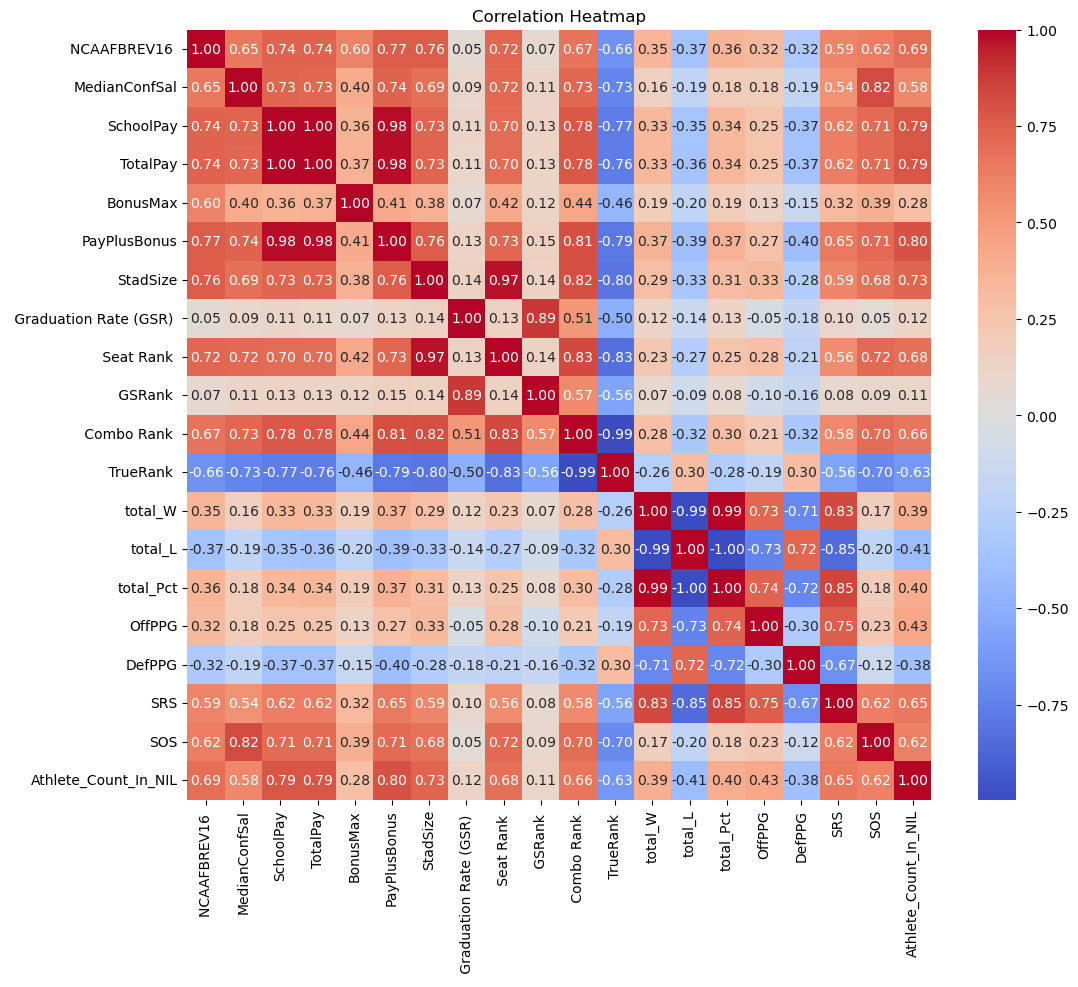

In [218]:
# Overall correlation heatmap
# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Correlation among all variables

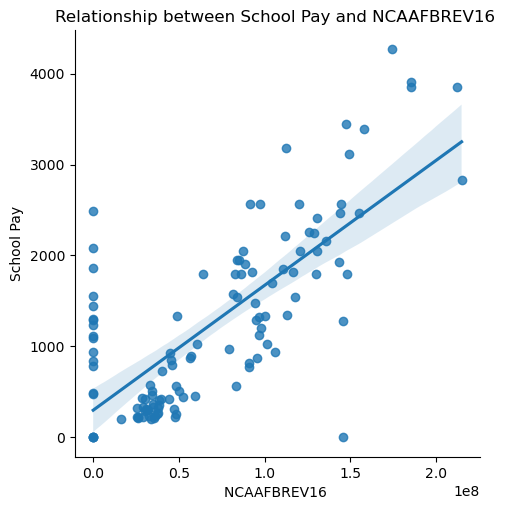

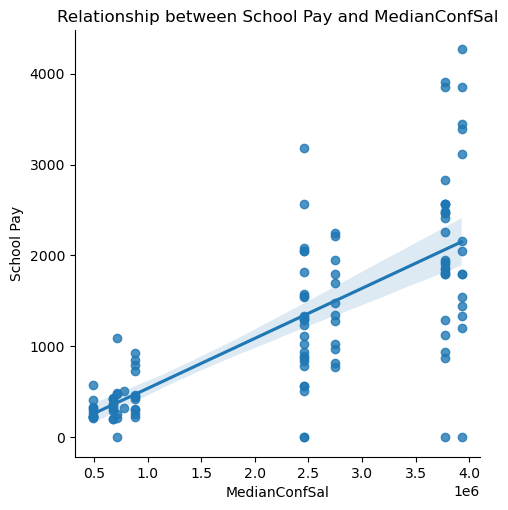

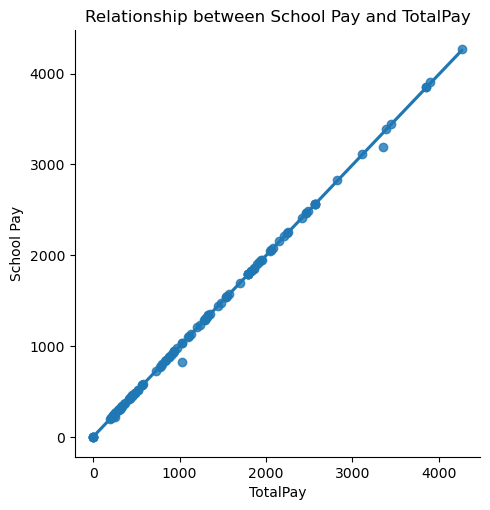

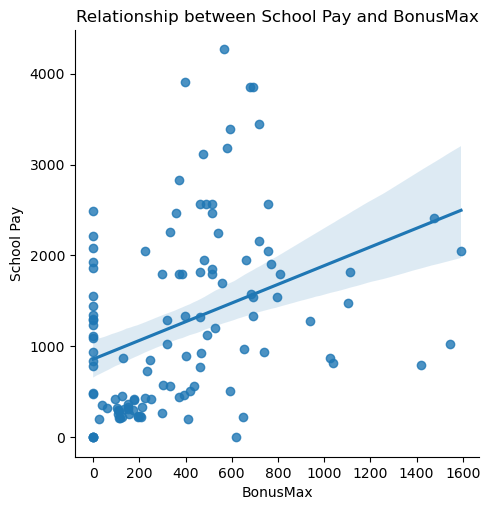

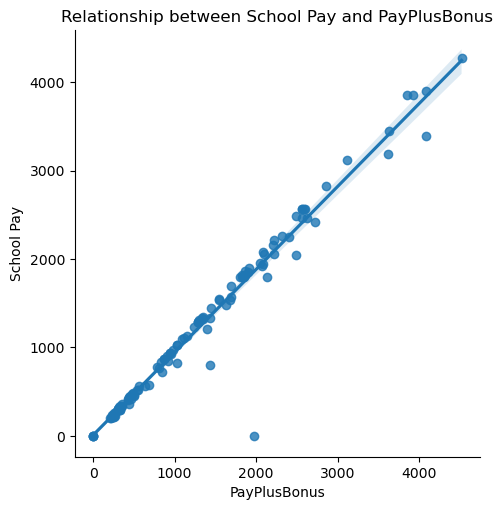

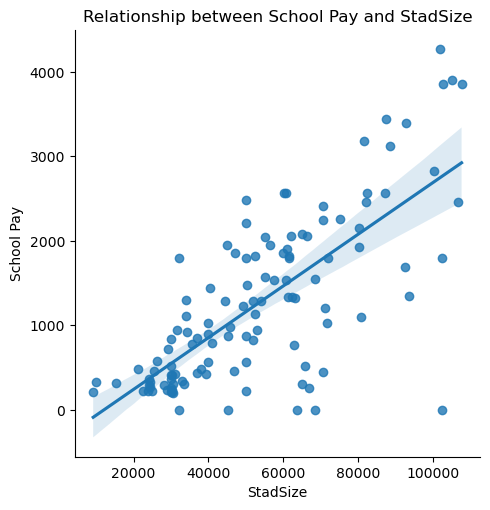

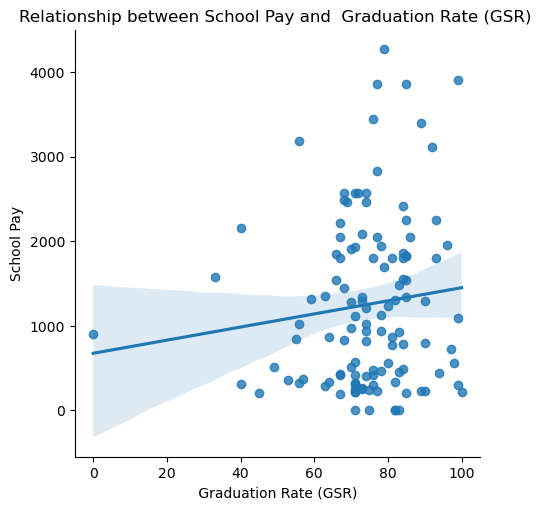

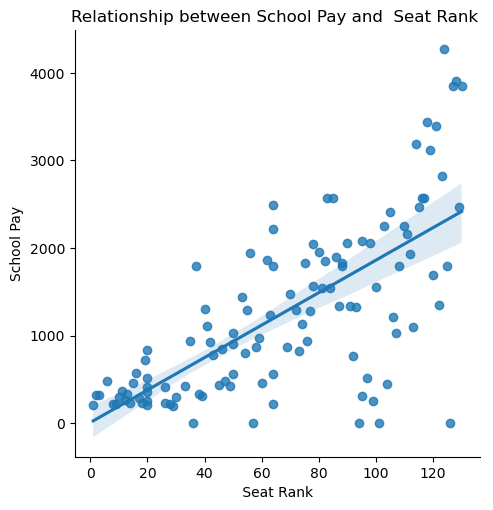

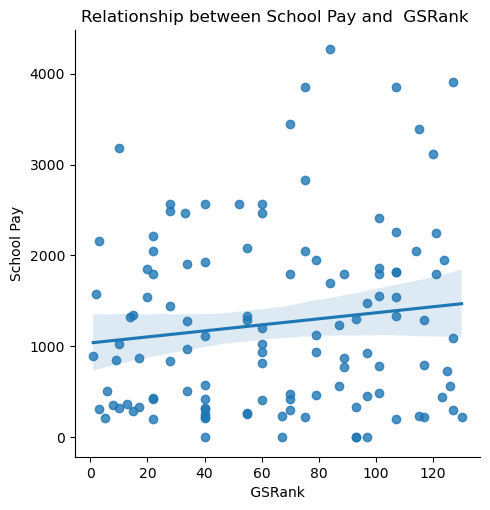

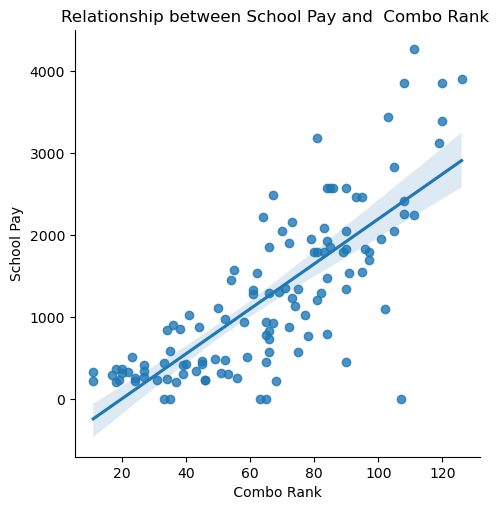

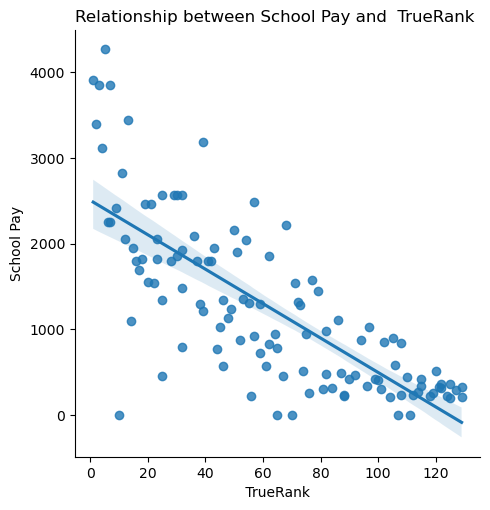

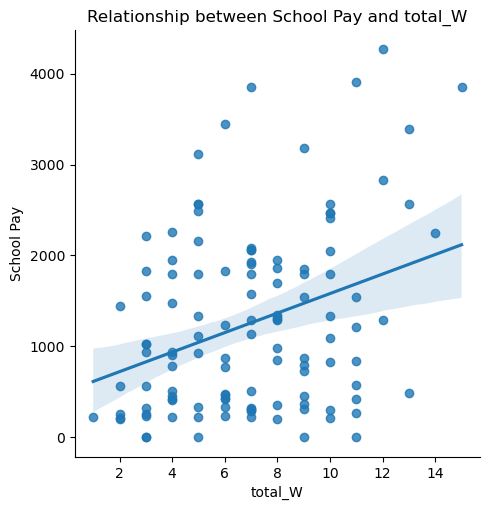

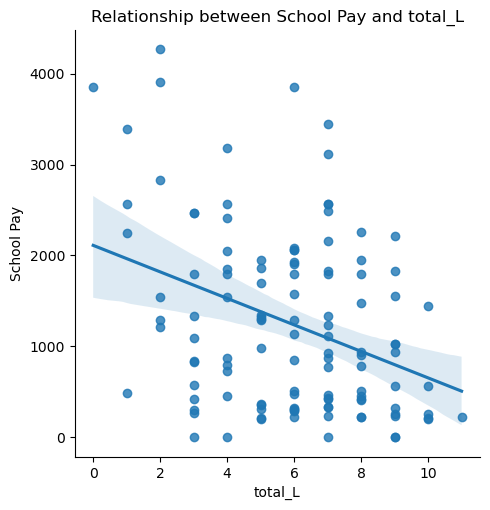

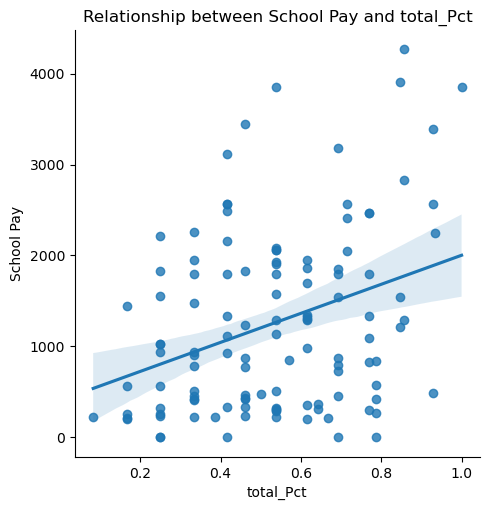

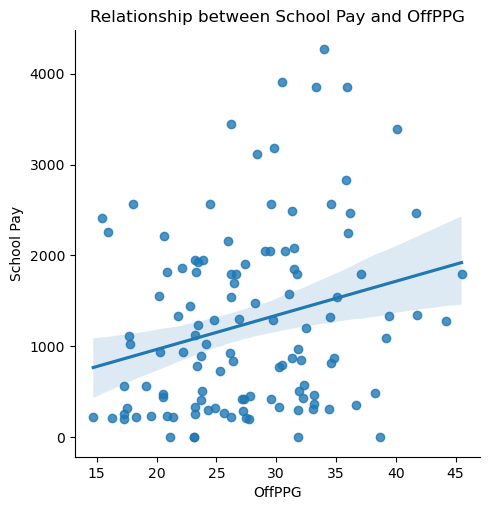

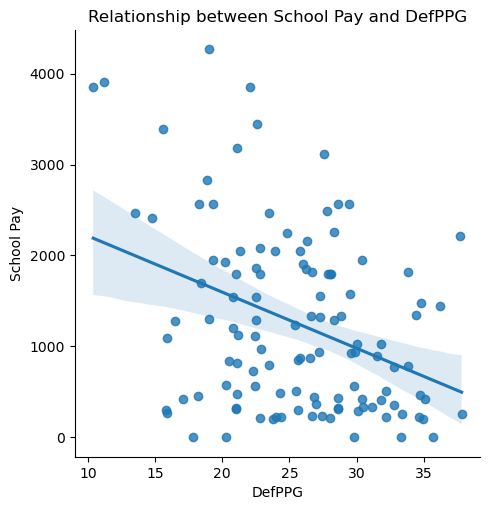

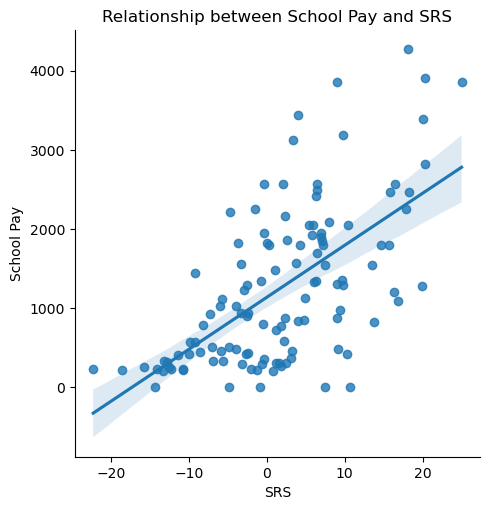

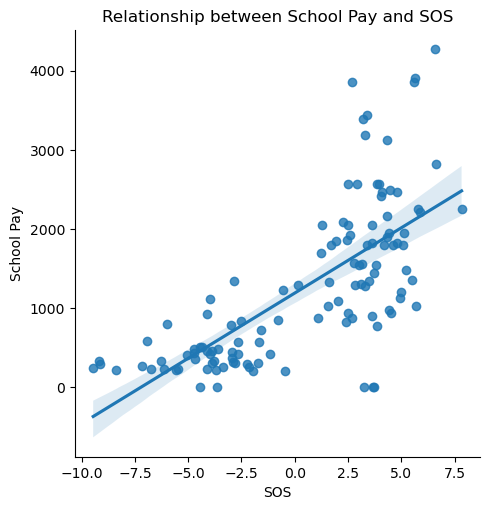

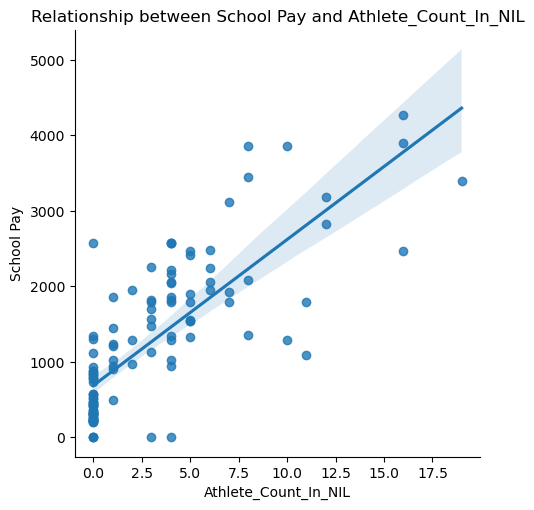

In [219]:
# Pay v. Performance Metrics: lmplots
# Select relevant columns for the lm plots
# Define the column to exclude
column_to_exclude = ['SchoolPay','School','Conf','Coach','APCurr','APPre', 'APHigh'] 
    # Categorical variables can't run linear regression

# Get all columns from merged_df except for the excluded column
columns_to_plot = merged_df.drop(column_to_exclude, axis=1).columns.tolist()

# Create individual lm plots
for column in columns_to_plot:
    sns.lmplot(x=column, y='SchoolPay', data=merged_df)
    plt.title(f'Relationship between School Pay and {column}')
    plt.xlabel(column)
    plt.ylabel('School Pay')
    plt.show()

These plots display which variables will be ideal to use in a regression model. Specifically, StadSize, Seat Rank, Combo Rank, TrueRank, SRS, and SOS.  

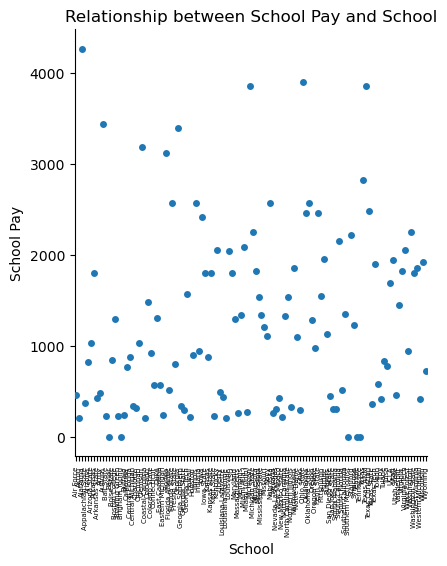

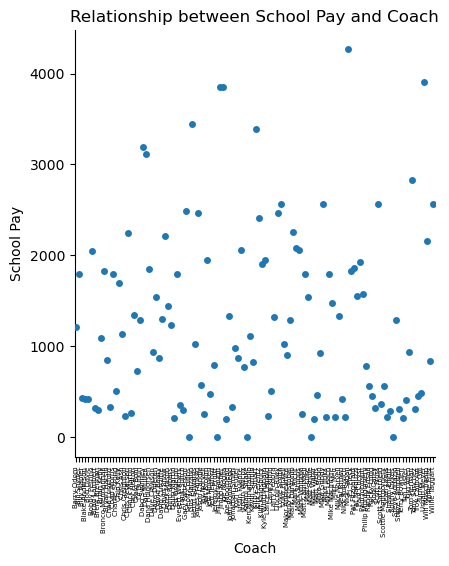

In [220]:
# Pay v. School and Coach Metrics: catplots
# Select relevant columns for the cat plots
# Define the column to plot
columns_to_plot = ['School', 'Coach']

for column in columns_to_plot:
    catplot = sns.catplot(x=column, y='SchoolPay', data=merged_df, kind='swarm')
    plt.title(f'Relationship between School Pay and {column}')
    plt.xlabel(column)
    plt.ylabel('School Pay')
    plt.tick_params(axis='x', rotation=90, labelsize=5)
    plt.show()

These plots prove that trying to account for School or Coach in a model will be fruitless as there is too much variation.

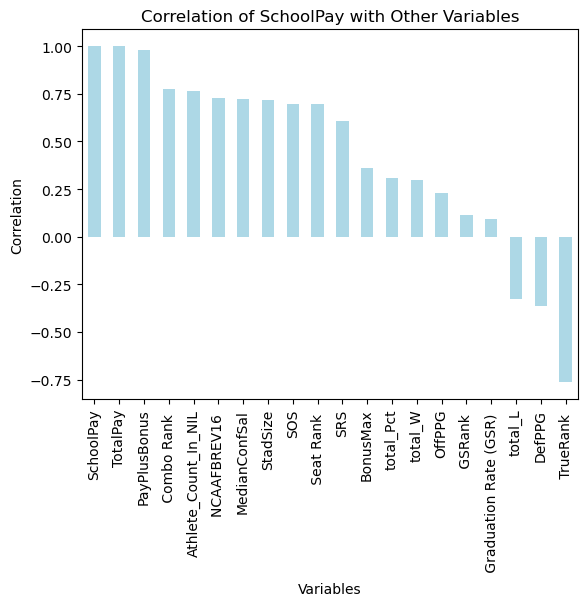

In [222]:
# Correlation between 'SchoolPay' and the other columns
# Select the relevant columns for correlation
correlation_columns = merged_df.iloc[3:,]

# Calculate the correlation between 'SchoolPay' and other columns
correlation_with_schoolpay = correlation_columns.corrwith(merged_df['SchoolPay'])

# Plot the correlation
correlation_with_schoolpay.sort_values(ascending=False).plot(kind='bar', color='lightblue')
plt.title("Correlation of SchoolPay with Other Variables")
plt.xlabel("Variables")
plt.ylabel("Correlation")
plt.show()

Further visualization of the impact of variables on SchoolPay.

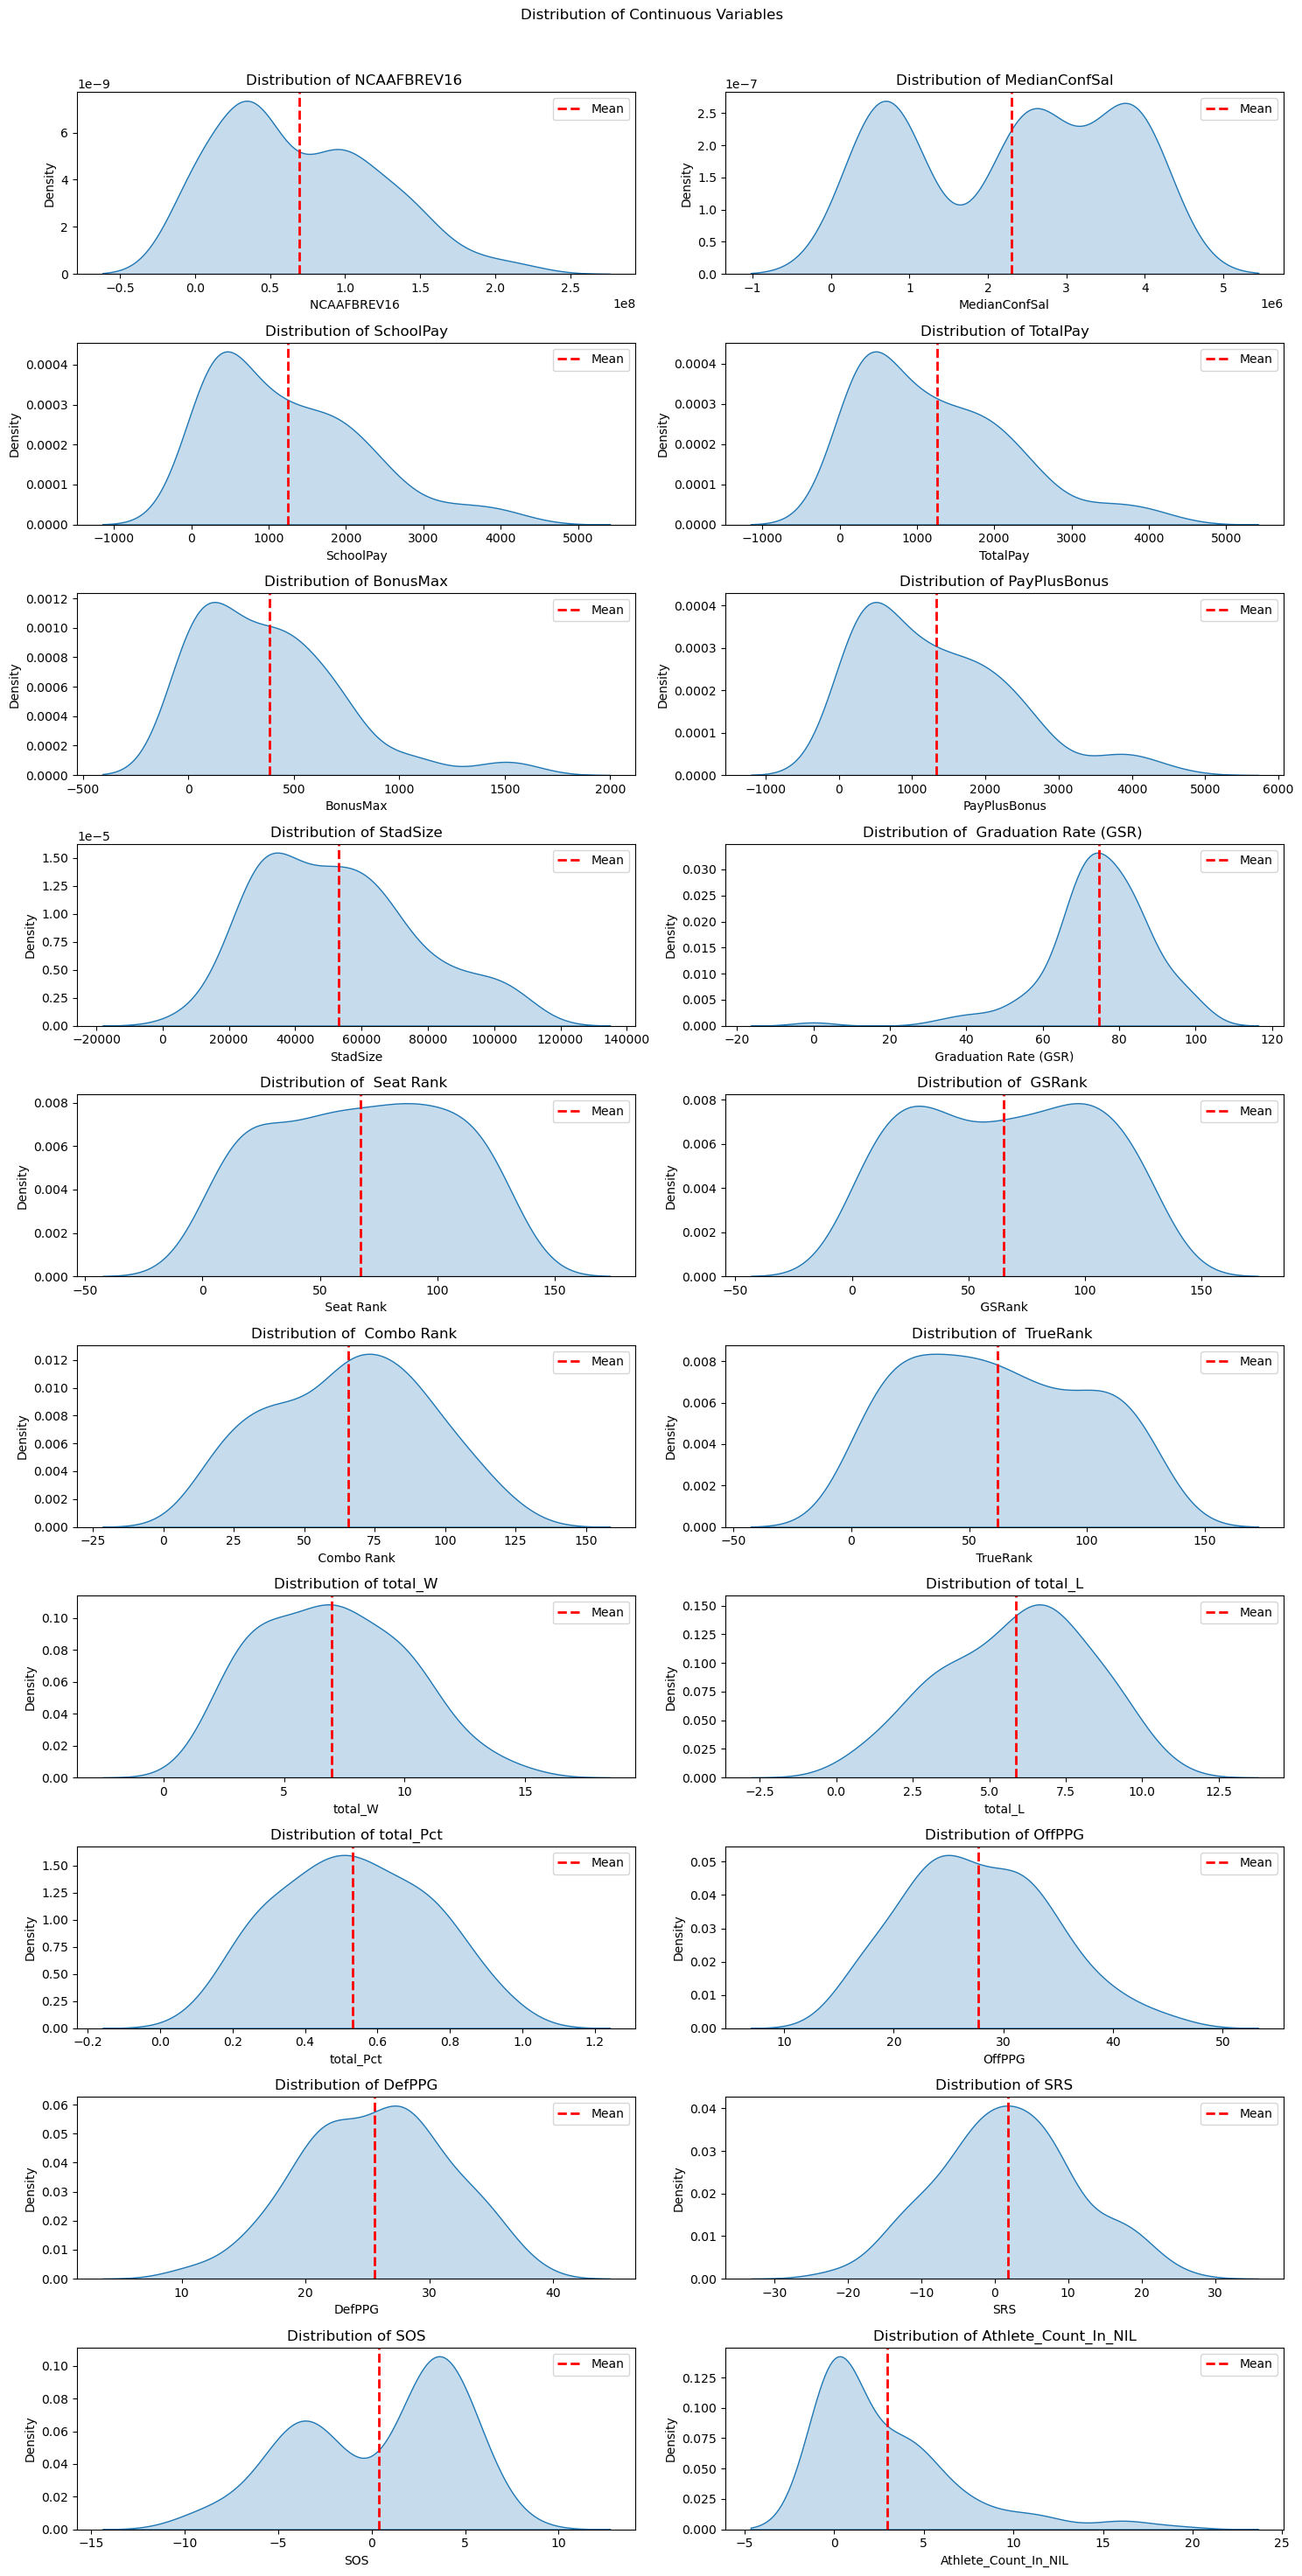

In [223]:
# Visualizing the distribution of continuous variables
# Select continuous variables
continuous_variables = merged_df.select_dtypes(include='number')
# Plot kernel density plots for each continuous variable in an 11x2 grid
fig, axes = plt.subplots(10, 2, figsize=(15, 30))
fig.suptitle('Distribution of Continuous Variables')

for i, column in enumerate(continuous_variables.columns):
    sns.kdeplot(merged_df[column], fill=True, ax=axes[i // 2, i % 2])
    
    # Add a vertical line at the mean
    axes[i // 2, i % 2].axvline(merged_df[column].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
    
    axes[i // 2, i % 2].set_title(f'Distribution of {column}')
    axes[i // 2, i % 2].legend()

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

These plots are helpful in visualizing the spread of each continuous variable.

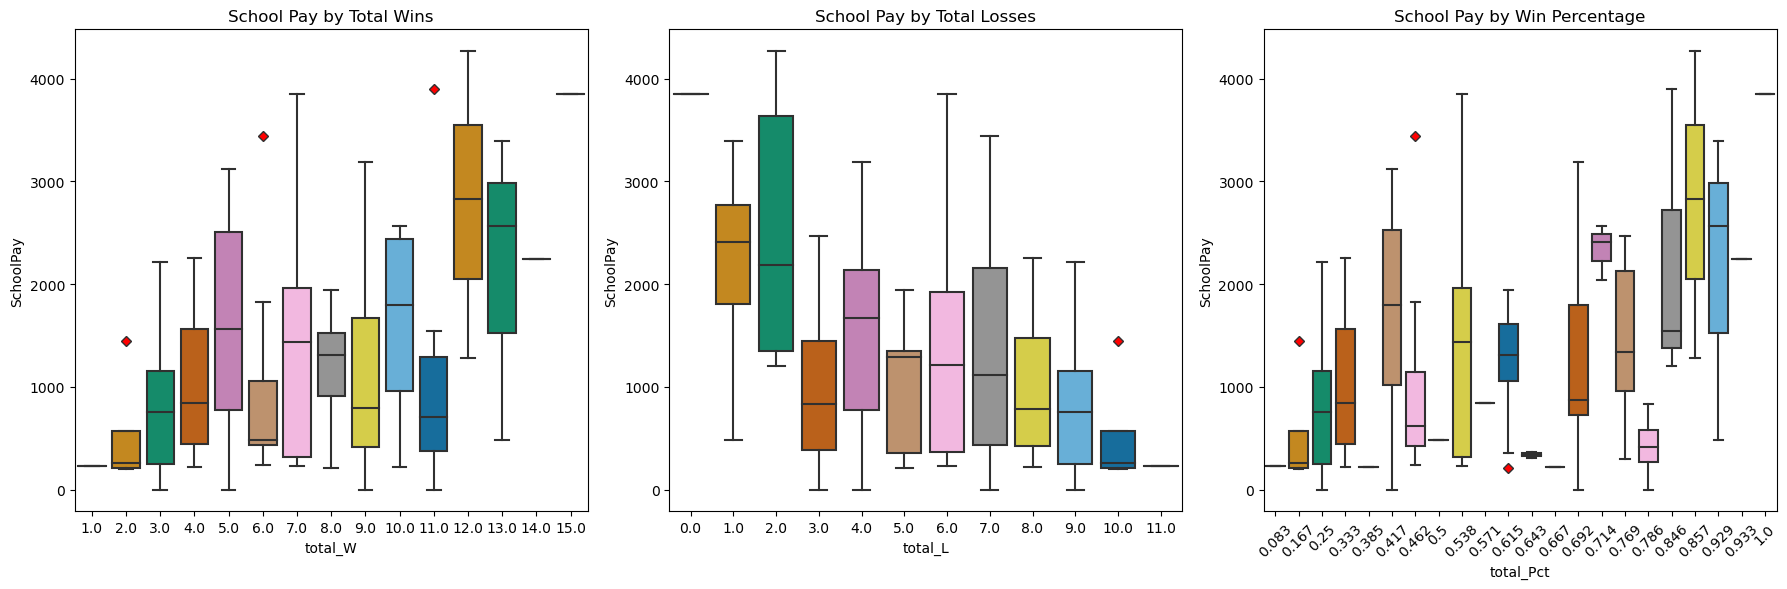

In [224]:
# Create subplots for each column
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Box plot for 'total_W'
sns.boxplot(x='total_W', y='SchoolPay', data=merged_df, ax=axes[0], palette='colorblind',
           flierprops=dict(markerfacecolor='r', marker='D'))
axes[0].set_title('School Pay by Total Wins')

# Box plot for 'total_L'
sns.boxplot(x='total_L', y='SchoolPay', data=merged_df, ax=axes[1], palette='colorblind',
           flierprops=dict(markerfacecolor='r', marker='D'))
axes[1].set_title('School Pay by Total Losses')

# Box plot for 'total_Pct'
sns.boxplot(x='total_Pct', y='SchoolPay', data=merged_df, ax=axes[2], palette='colorblind',
           flierprops=dict(markerfacecolor='r', marker='D'))
axes[2].set_title('School Pay by Win Percentage')
axes[2].tick_params(axis='x', rotation=45)  # Rotate x-ticks for better readability

plt.tight_layout()
plt.show()

While not going to be used in the model based on the lmplots above, it is still interesting to see how coaches were paid when factoring the 2023 win records.

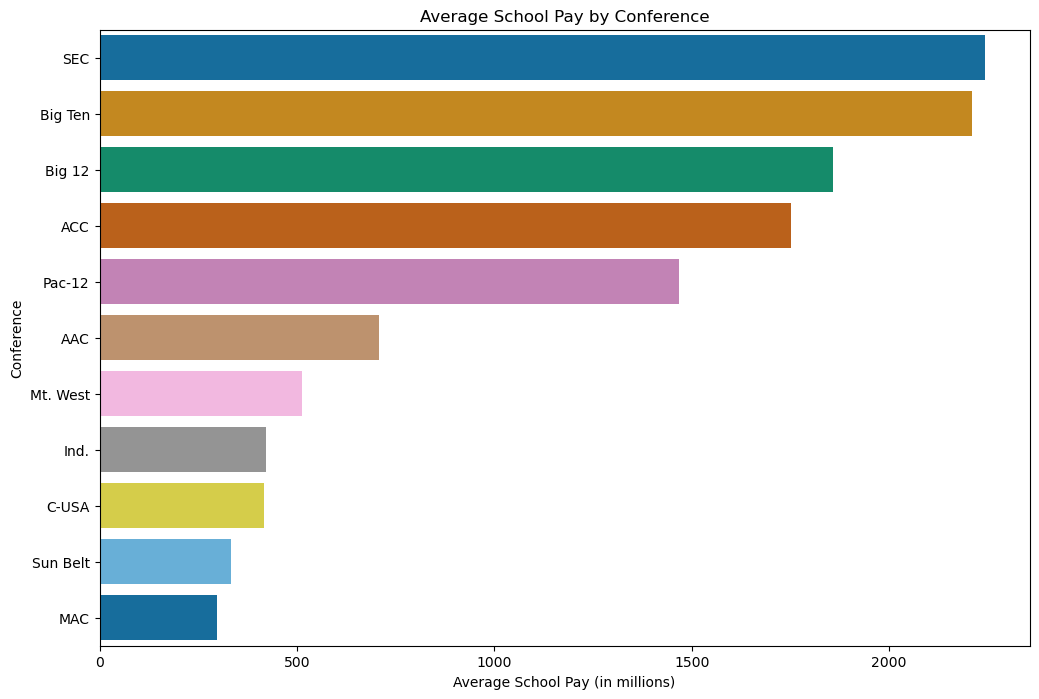

In [225]:
# Group by conference and calculate the average pay, then sort the DataFrame
conference_pay_df = merged_df.groupby('Conf')['SchoolPay'].mean().reset_index()
conference_pay_df = conference_pay_df.sort_values(by='SchoolPay', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='SchoolPay', y='Conf', data=conference_pay_df, palette='colorblind', order=conference_pay_df['Conf'])
plt.title('Average School Pay by Conference')
plt.xlabel('Average School Pay (in millions)')
plt.ylabel('Conference')
plt.show()

Wealth and Success are not spread equally among college football conferences, and this plot shows which conferences are able to pay higher salaries.

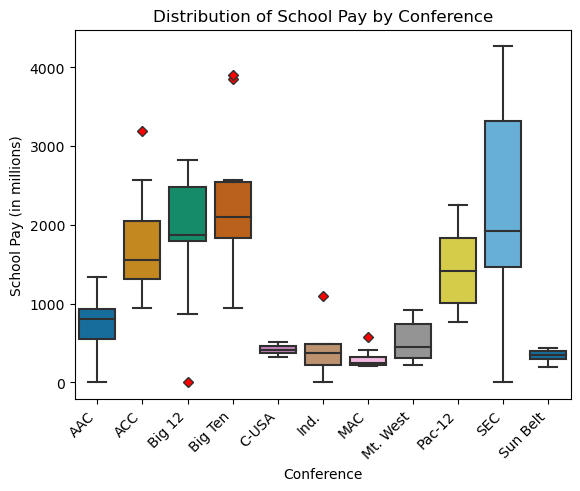

In [226]:
# Create a boxplot with outliers marked
boxplot = sns.boxplot(x='Conf', y='SchoolPay', data=merged_df, palette='colorblind',
                      flierprops=dict(markerfacecolor='r', marker='D'))
plt.title('Distribution of School Pay by Conference')
plt.xlabel('Conference')
plt.ylabel('School Pay (in millions)')
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()


Another view of conference salary, this time showing the spread of how each coach is paid by conference. 

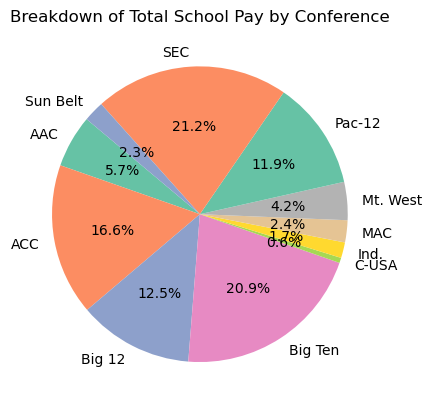

In [227]:
# Group by conference and calculate the total SchoolPay for each conference
conference_totals = merged_df.groupby('Conf')['SchoolPay'].sum().reset_index()

# Plotting the pie chart
#plt.figure(figsize=(10, 8))
plt.pie(conference_totals['SchoolPay'], labels=conference_totals['Conf'], autopct='%1.1f%%',
        startangle=140, colors=sns.color_palette('Set2'))
plt.title('Breakdown of Total School Pay by Conference')
plt.show()

Lastly, (and just for fun), here is a pie chart showing how each conference accounts for the sum of salaries in the SchoolPay column. 

## Step 4: Model relationships between data using the appropriate analytical methodologies matched to the information and the needs of clients and users

Looking back at our correlation matrix, and knowing that we have a lot of data to use, we will begin our modeling by first identifying and removing outliers before building our model.

In [228]:
# First, we'll identify any outliers that may be throwing off our data

# One-hot encode categorical variables
encoded_df = pd.get_dummies(merged_df, columns=['School', 'Conf', 'Coach'])

# Initialize Isolation Forest model
isolation_forest = IsolationForest(contamination=0.05)  # Adjust contamination based on expected proportion of outliers

# Fit Isolation Forest model
isolation_forest.fit(encoded_df)  # Use the one-hot encoded data

# Predict outliers (anomaly labels)
outlier_labels = isolation_forest.predict(encoded_df)  # Use the one-hot encoded data

# Add outlier labels to DataFrame
merged_df['Outlier'] = outlier_labels

# Identify outliers (Outlier = -1)
outliers = merged_df[merged_df['Outlier'] == -1]
print('\nOutliers:')
print(outliers)


Outliers:
        School     Conf         Coach  NCAAFBREV16   MedianConfSal  \
2      Alabama      SEC    Nick Saban   174307419.0        3929800   
30     Florida      SEC    Dan Mullen   149165475.0        3929800   
34     Georgia      SEC   Kirby Smart   157852479.0        3929800   
42        Iowa  Big Ten  Kirk Ferentz   130681467.0        3775000   
76  Ohio State  Big Ten   Urban Meyer   185409602.0        3775000   
97   Texas A&M      SEC  Jimbo Fisher   211960034.0        3929800   

      SchoolPay     TotalPay     BonusMax  PayPlusBonus  StadSize  ...  \
2   4266.563945  4266.563945   564.971751   4523.369286    101821  ...   
30  3117.616846  3117.616846   475.089882   3117.616846     88548  ...   
34  3391.679507  3391.679507   590.652286   4085.053929     92746  ...   
42  2413.970211  2413.970211  1476.630714   2722.136620     70585  ...   
76  3903.441192  3903.441192   398.048279   4083.204931    104944  ...   
97  3852.080123  3852.080123   693.374422   3852.08012

In [229]:
# Now that we know which Coaches are not useful for our model, we'll drop those

# Remove outliers from DataFrame
cleaned_df = merged_df[merged_df['Outlier'] == 1]

# Drop the 'Outlier' column from cleaned_df
cleaned_df = cleaned_df.drop(columns=['Outlier'])

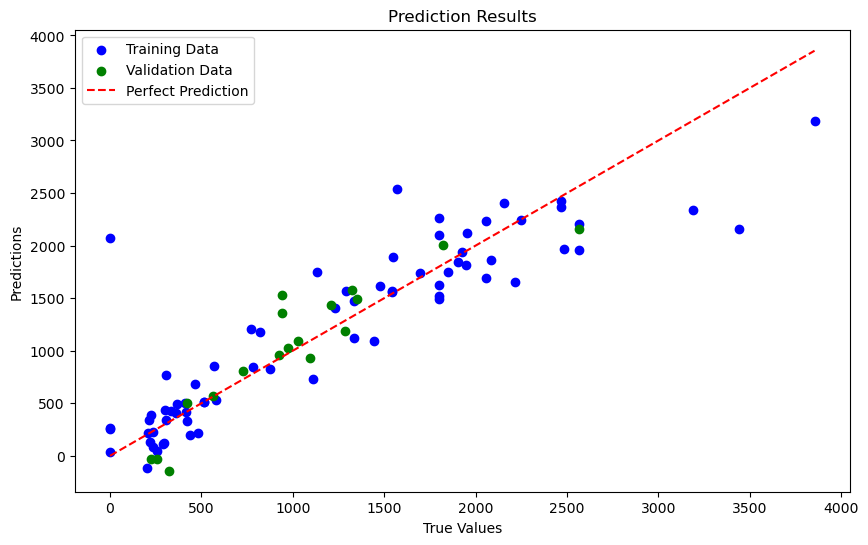

Mean squared error = 71259.24
Explained variance score = 0.78
R2 score = 0.78
                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     12.36
Date:                Sun, 28 Jan 2024   Prob (F-statistic):           7.24e-13
Time:                        17:31:34   Log-Likelihood:                -528.68
No. Observations:                  71   AIC:                             1093.
Df Residuals:                      53   BIC:                             1134.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [232]:
# Now that the outliers are removed, let's run a linear regression model using the variables with clear patterns
        # in the lmplots and those needed to answer the research questions
X = cleaned_df[['Conf', 'StadSize',' Graduation Rate (GSR) ', ' Seat Rank ', ' Combo Rank ', ' TrueRank ',
                'SRS', 'SOS']]
    
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['Conf'])

y = cleaned_df['SchoolPay']

# Split the data into training and temporary sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# Split the temporary set into validation and training sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)
    
# Fit the model using statsmodels
X_train = st.add_constant(X_train)  # Add constant term for intercept
model = st.OLS(y_train, X_train).fit()

# Make predictions on validation data
X_val = st.add_constant(X_val)  # Add constant term for intercept
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Plotting
plt.figure(figsize=(10, 6))

# Plotting training data
plt.scatter(y_train, y_train_pred, color='blue', label="Training Data")

# Plotting test data
plt.scatter(y_val, y_val_pred, color='green', label='Validation Data')

# Plotting a diagonal line (y=x)
plt.plot([min(y_train.min(), y_val.min()), max(y_train.max(), y_val.max())],
         [min(y_train.min(), y_val.min()), max(y_train.max(), y_val.max())],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title('Prediction Results')
plt.legend()
plt.show()

# Evaluation
print("Mean squared error =", round(sm.mean_squared_error(y_val, y_val_pred), 2))
print("Explained variance score =", round(sm.explained_variance_score(y_val, y_val_pred), 2))
print("R2 score =", round(sm.r2_score(y_val, y_val_pred), 2))
print(model.summary())

### Interpretations
- Mean Squared Error (MSE): MSE of 71259.24 indicates that, on average, the squared difference between the predicted and actual values is approximately 71,259.24.

- Explained Variance Score: 0.78 indicates that your model explains 78% of the variance in the dependent variable (SchoolPay) in the test set.

- R-squared (R2) Score: 0.78 indicates that 78% of the variance in the dependent variable in the test set is explained by the independent variables.

- The R-squared Score from the model summary: 0.799 (0.734 adjusted) indicated that 79.9% (73.4% adjusted) of the variance in the dependent variable from both the test and training sets is explained by the indepedent variables. 

- Low F-statistic indicates that the null hypothesis can be rejected, meaning that our model is statistically significant and that it is highly unlikely that all coefficients in the model are equal to zero.
 

While there are a lot of features with high p-values, it is important to understand that they are important metrics when hiring a football coach. For example, a coach at a school with a smaller stadium doesn't allow for as much revenue to be brought in as a coach at school with a large stadium. As such, we will explore their effects on the model further.

## Next Steps:
- Validate your model: Assess the model's performance on unseen data to ensure that it generalizes well as well as the predictive power of the model considering the non-significant variables.
- Interpret the coefficients: To understand the impact of each independent variable on the dependent variable.

In [233]:
def perform_linear_regression(df, features, target, test_size=0.2, random_state=42, cv_folds=5):
    # Separate dataframe into features (X) and target (y)
    X = features  # Use the features DataFrame
    y = df[target]
    
    # Split the data into training and temporary sets
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Split the temporary set into validation and training sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=test_size, random_state=random_state)
    
    # Fit the model using statsmodels
    X_train = st.add_constant(X_train)  # Add constant term for intercept
    model = st.OLS(y_train, X_train).fit()
    
    # Score the model on the validation data
    X_val = st.add_constant(X_val)
    validation_score = model.rsquared_adj
    print(f"Validation Score: {validation_score}")
    
    # Initialize KFold cross-validation
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    # Perform k-Fold Cross Validation on the training set
    cv_scores = []
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
        
        X_train_cv = st.add_constant(X_train_cv)  # Add constant term for intercept
        model_cv = st.OLS(y_train_cv, X_train_cv).fit()
        
        cv_score = model_cv.rsquared_adj
        cv_scores.append(cv_score)
    
    cv_scores = np.array(cv_scores)
    print(f"Cross-validation Scores: {cv_scores}")
    print(f"Average Cross-validation Score: {cv_scores.mean()}")
    
    # Evaluate the model's performance on the test set
    X_test = st.add_constant(X_test)
    test_score = model.rsquared_adj
    print(f"Test Score: {test_score}")
    
    return validation_score, cv_scores, test_score

# Define features and target
features = cleaned_df[['Conf', 'StadSize',' Graduation Rate (GSR) ', ' Seat Rank ', ' Combo Rank ', ' TrueRank ',
                'SRS', 'SOS']]
features = pd.get_dummies(features, columns=['Conf'])
target = 'SchoolPay'

# Perform linear regression with cross-validation and validation set
perform_linear_regression(cleaned_df, features, target)

Validation Score: 0.7339883596918034
Cross-validation Scores: [0.66091926 0.88642441 0.7259396  0.68631471 0.73049765]
Average Cross-validation Score: 0.7380191265511662
Test Score: 0.7339883596918034


(0.7339883596918034,
 array([0.66091926, 0.88642441, 0.7259396 , 0.68631471, 0.73049765]),
 0.7339883596918034)

### Interpretations
- Validation Score: 0.734
- Average Cross-validation Score: 738
- Test Score: 0.734

These scores suggest that the model explains a high percentage of the variance in the target variable (SchoolPay) and generalizes well to unseen data. Overall, the model appears to be performing excellently on all three splits of the dataset, indicating that it is a robust and reliable model for predicting SchoolPay based on the given features.

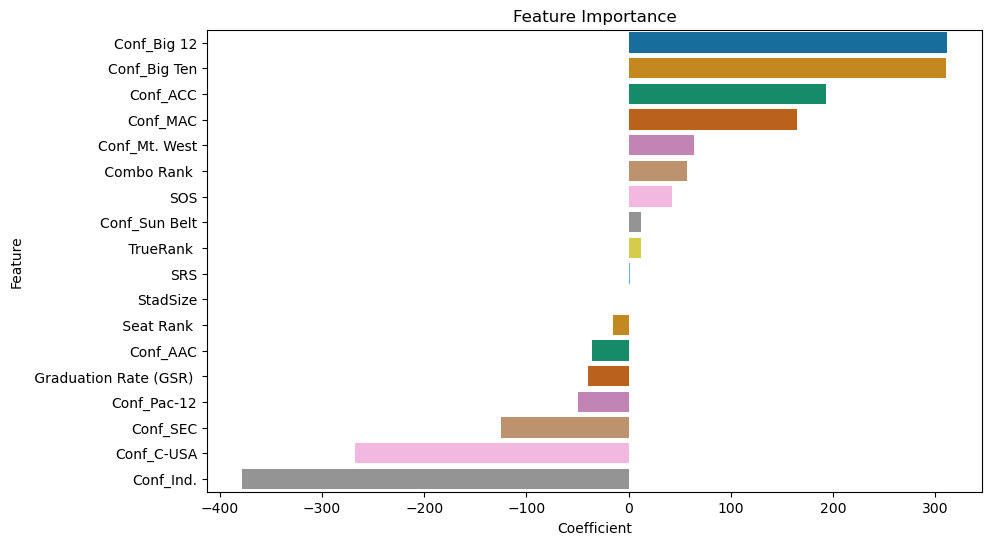

In [236]:
# Investigating feature importace in the model
# Get the coefficients of the linear regression model
coefficients = model.params[1:] # Ignoring the const

# Get the names of the features
feature_names = X.columns  

# Create a DataFrame to display the feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient magnitude in descending order
feature_importance_df = feature_importance_df.sort_values(by='Coefficient', ascending=False)


# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df, palette='colorblind')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

This plot shows that the Conf variable is the most important variable in the model compared to the numerical categories, and that TrueRank, SRS, StadSize, and Seat Rank have little importance on the model.

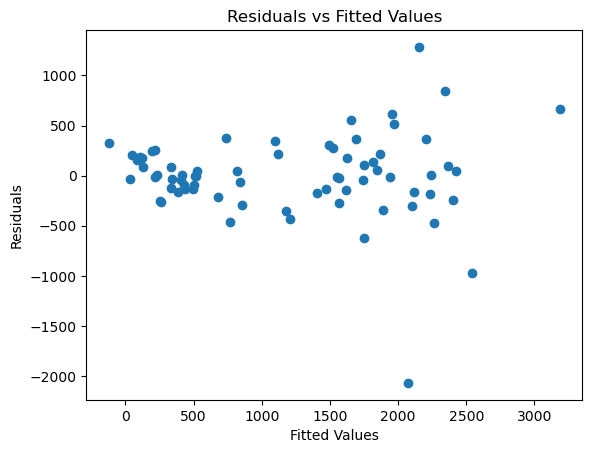

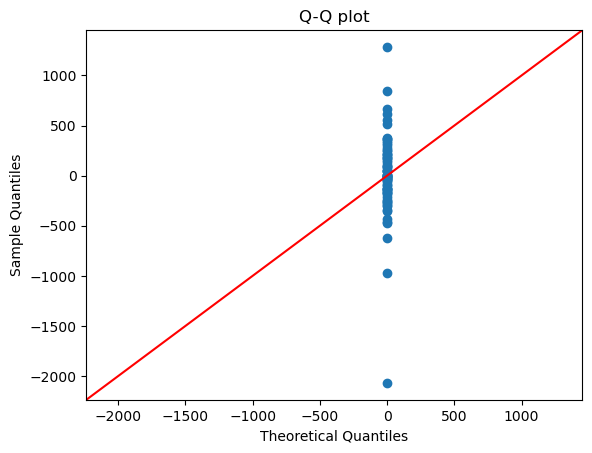

Durbin-Watson statistic: 2.1886673168639974


In [237]:
# Residual Analysis
# Generate model residuals
residuals = model.resid

# Residuals vs Fitted plot
plt.scatter(model.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# QQ plot
st.qqplot(residuals, line='45')
plt.title('Q-Q plot')
plt.show()

# Durbin-Watson test
dw = st.stats.durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw}")

Overall, based on these plots:

The Residuals vs Fitted Values plot indicates a generally acceptable pattern, with some potential heteroscedasticity or nonlinearity.

The Q-Q plot suggests that the residuals approximately follow a normal distribution.

The Durbin-Watson statistic indicates mild positive autocorrelation, which may affect the efficiency of the parameter estimates but does not invalidate the model.

In summary, while there are some areas for potential improvement (e.g., addressing heteroscedasticity and autocorrelation), the model appears to generally meet the assumptions of linear regression, particularly regarding normality of residuals. 

### Considering the above analysis, we'll remove the least important features and run the model again.

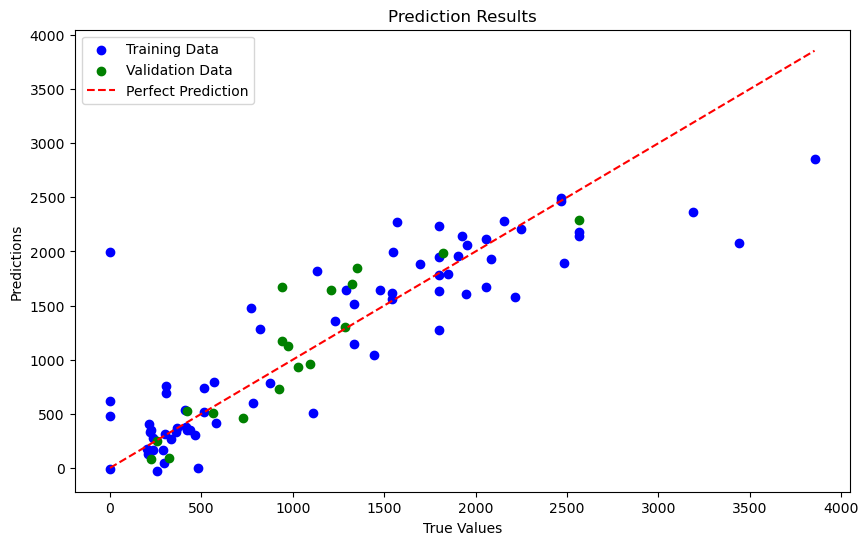

Mean squared error = 84092.32
Explained variance score = 0.75
R2 score = 0.74
                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     14.85
Date:                Sun, 28 Jan 2024   Prob (F-statistic):           7.99e-14
Time:                        17:58:17   Log-Likelihood:                -533.08
No. Observations:                  71   AIC:                             1094.
Df Residuals:                      57   BIC:                             1126.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [247]:
X = cleaned_df[['Conf',' Graduation Rate (GSR) ', ' Combo Rank ','SOS']]
    
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['Conf'])

y = cleaned_df['SchoolPay']

# Split the data into training and temporary sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# Split the temporary set into validation and training sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)
    
# Fit the model using statsmodels
X_train = st.add_constant(X_train)  # Add constant term for intercept
model = st.OLS(y_train, X_train).fit()

# Make predictions on validation data
X_val = st.add_constant(X_val)  # Add constant term for intercept
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Plotting
plt.figure(figsize=(10, 6))

# Plotting training data
plt.scatter(y_train, y_train_pred, color='blue', label="Training Data")

# Plotting test data
plt.scatter(y_val, y_val_pred, color='green', label='Validation Data')

# Plotting a diagonal line (y=x)
plt.plot([min(y_train.min(), y_val.min()), max(y_train.max(), y_val.max())],
         [min(y_train.min(), y_val.min()), max(y_train.max(), y_val.max())],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title('Prediction Results')
plt.legend()
plt.show()

# Evaluation
print("Mean squared error =", round(sm.mean_squared_error(y_val, y_val_pred), 2))
print("Explained variance score =", round(sm.explained_variance_score(y_val, y_val_pred), 2))
print("R2 score =", round(sm.r2_score(y_val, y_val_pred), 2))
print(model.summary())

While the r-squared and variance metrics remained the same, the MSE score raised here indicating that the average difference between test and validation predictions slightly worsened.

In [258]:
# Define updated features and target
features = cleaned_df[['Conf', 'StadSize',' Graduation Rate (GSR) ',' Combo Rank ','SOS']]
features = pd.get_dummies(features, columns=['Conf'])
target = 'SchoolPay'

# Perform linear regression with cross-validation and validation set
perform_linear_regression(cleaned_df, features, target)

Validation Score: 0.7301712312834582
Cross-validation Scores: [0.67254685 0.83246649 0.71944363 0.69553584 0.72611171]
Average Cross-validation Score: 0.7292209040449507
Test Score: 0.7301712312834582


(0.7301712312834582,
 array([0.67254685, 0.83246649, 0.71944363, 0.69553584, 0.72611171]),
 0.7301712312834582)

These metrics suggest that the model remained the same compared to the cross-validation results of the previous model.

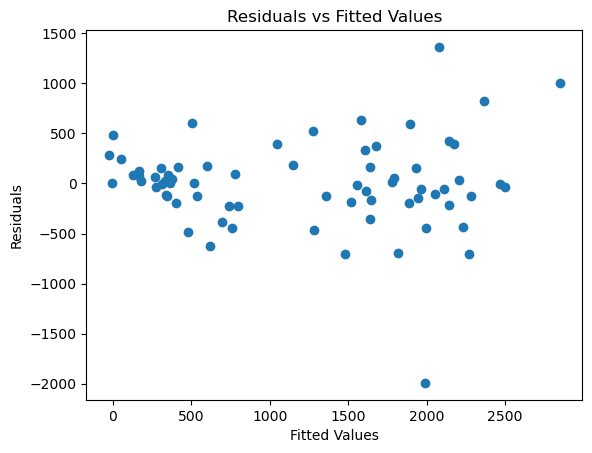

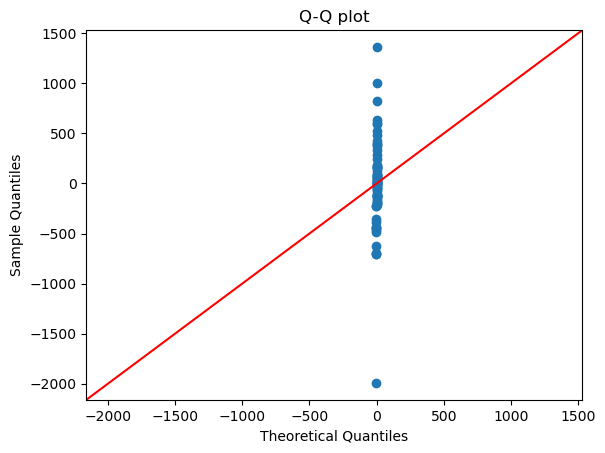

Durbin-Watson statistic: 2.20063768174945


In [249]:
# Residual Analysis
# Generate model residuals
residuals = model.resid

# Residuals vs Fitted plot
plt.scatter(model.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# QQ plot
st.qqplot(residuals, line='45')
plt.title('Q-Q plot')
plt.show()

# Durbin-Watson test
dw = st.stats.durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw}")

The residuals continue to appear well for the purposes of the model. The Durbin-Watson statistic is slightly higher now, but this doesn't mean anything in terms of our model.

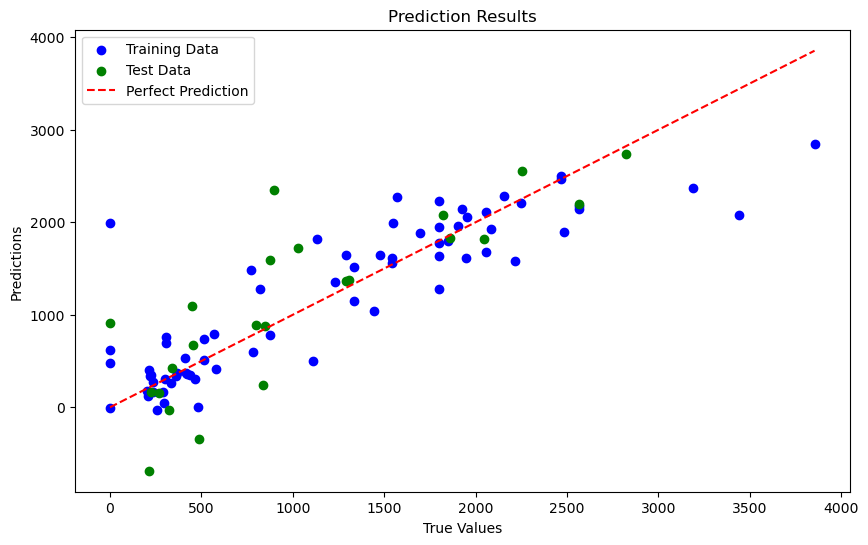

Mean squared error = 294586.47
Explained variance score = 0.55
R2 score = 0.54


In [257]:
# Predicting on unseen test data
# Make predictions on validation data
X_test = st.add_constant(X_test)  # Add constant term for intercept
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plotting
plt.figure(figsize=(10, 6))

# Plotting training data
plt.scatter(y_train, y_train_pred, color='blue', label="Training Data")

# Plotting test data
plt.scatter(y_test, y_test_pred, color='green', label='Test Data')

# Plotting a diagonal line (y=x)
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title('Prediction Results')
plt.legend()
plt.show()

# Evaluation
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2))
print("Explained variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_test_pred), 2))

## Step 5: iNterpret the data, model, analysis, and findings. 
Using the results of the model and the available 2023 Syracuse football information:
- Conference: Atlantic Coast Conference (ACC)
- Record: 6-7 (0.46 win percentage)
- Stadium Size: 49,250
- Graduation Rate: 94%
- Offensive points per game: 23.5
- Defensive points per game: 25.4
- SRS: -2.93
- SOS: -0.55
- Unranked in the AP Polls for the 2023 season
- Note: Coach Dino Babers was fired on on November 19, 2023. Fran Brown has been officially introduced as the newest head coach as of December 4, 2023.

In [250]:
print('Syracuse Data: ')
syracuse_data = cleaned_df[cleaned_df['School'] == 'Syracuse'][['Conf', ' Graduation Rate (GSR) ', ' Combo Rank ',
                                                                'SOS']]
print(syracuse_data)
print()
print('Note: GSR and Combo Rank were taken from 2016')

Syracuse Data: 
   Conf   Graduation Rate (GSR)    Combo Rank    SOS
93  ACC                       80            73 -0.55

Note: GSR and Combo Rank were taken from 2016


In [251]:
print('Coefficients:')
print(model.params)

Coefficients:
const                      1300.080503
 Graduation Rate (GSR)      -25.818127
 Combo Rank                  25.591977
SOS                          49.059072
Conf_AAC                    -47.164241
Conf_ACC                    280.038339
Conf_Big 12                 414.525554
Conf_Big Ten                398.496901
Conf_C-USA                  102.919273
Conf_Ind.                  -494.227902
Conf_MAC                    395.744226
Conf_Mt. West                58.742600
Conf_Pac-12                  84.445920
Conf_SEC                    -62.436834
Conf_Sun Belt               168.996667
dtype: float64


## Questions to answer:

### 1. What is the recommended salary for the Syracuse football coach?
Using the model and information above, the recommended salary will be calculcated using the following function:

In [252]:
# Salary recommendation

def recommend_salary(features, model):
    # Extract coefficients from the model
    coefficients = model.params
    
    # Calculate the salary based on coefficients and features
    salary = coefficients['const']
    for feature, coef in coefficients.items():
        if feature != 'const':
            salary += coef * features[feature]
    
    return salary

# Usage
# Define features for the recommendation
features = {
    ' Graduation Rate (GSR) ': 94,
    ' Combo Rank ': 73,
    'SOS': -0.55,
    'Conf_AAC': 0,
    'Conf_ACC': 1,
    'Conf_Big 12': 0,
    'Conf_Big Ten': 0,
    'Conf_C-USA': 0,
    'Conf_Ind.': 0,
    'Conf_MAC': 0,
    'Conf_Mt. West': 0,
    'Conf_Pac-12': 0,
    'Conf_SEC': 0,
    'Conf_Sun Belt': 0}

# Use the function to recommend salary based on the provided features and the model
recommended_salary = recommend_salary(features, model) * 1000  # Multiply by 1000 for $ formatting
print(f"Recommended salary for Syracuse Head Coach: ${recommended_salary:,.2f}")  # Format with comma separator

Recommended salary for Syracuse Head Coach: $994,446.81


### 2. What would his salary be if we were still in the Big East? What if we went to the Big Ten?

In [253]:
# Defining Big East features
east_features = {
    ' Graduation Rate (GSR) ': 94,
    ' Combo Rank ': 73,
    'SOS': -0.55,
    'Conf_AAC': 0,
    'Conf_ACC': 0,
    'Conf_Big 12': 0,
    'Conf_Big Ten': 0,
    'Conf_C-USA': 0,
    'Conf_Ind.': 0,
    'Conf_MAC': 0,
    'Conf_Mt. West': 0,
    'Conf_Pac-12': 0,
    'Conf_SEC': 0,
    'Conf_Sun Belt': 0}

# Defining Big Ten features
ten_features = {
    ' Graduation Rate (GSR) ': 94,
    ' Combo Rank ': 73,
    'SOS': -0.55,
    'Conf_AAC': 0,
    'Conf_ACC': 0,
    'Conf_Big 12': 0,
    'Conf_Big Ten': 1,
    'Conf_C-USA': 0,
    'Conf_Ind.': 0,
    'Conf_MAC': 0,
    'Conf_Mt. West': 0,
    'Conf_Pac-12': 0,
    'Conf_SEC': 0,
    'Conf_Sun Belt': 0}

# Use the function to recommend salary based on the provided features and the model
recommended_east_salary = recommend_salary(east_features, model) * 1000  # Multiply by 1000 for $ formatting
print(f"Recommended salary for Syracuse Head Coach if in Big East: ${recommended_salary:,.2f}")
print()
recommended_ten_salary = recommend_salary(ten_features, model) * 1000  # Multiply by 1000 for $ formatting
print(f"Recommended salary for Syracuse Head Coach if in Big Ten: ${recommended_salary:,.2f}")

Recommended salary for Syracuse Head Coach if in Big East: $994,446.81

Recommended salary for Syracuse Head Coach if in Big Ten: $994,446.81


It's interesting to note that there is no salary difference among conference.

### 3. What schools did we drop from our data and why?


In [254]:
# Going back to our top and bottom 25 coaches from above

# Check where schools in outliers['School'] are present in top_25_coaches['School']
top_common_schools = outliers['School'].isin(top_25_coaches['School'])

# Check where schools in outliers['School'] are present in bot_25_coaches['School']
bot_common_schools = outliers['School'].isin(bot_25_coaches['School'])


common_schools = pd.concat([outliers['School'][top_common_schools], outliers['School'][bot_common_schools]])

# Create a new column indicating whether the school is in the top or bottom 25
outliers['Top_or_Bottom'] = ['Top 25' if school in top_25_coaches['School'].values else 'Bottom 25' for school in outliers['School']]

# Reset the index of the outliers DataFrame
outliers.reset_index(drop=True, inplace=True)

# Merge the outliers DataFrame with the top_25_coaches DataFrame on the "School" column
merged_outliers = outliers.merge(top_25_coaches[['School']], on='School', how='left')

print("Outlier schools and their rank among the highest-paid coaches in the top 25 list:")
for school in merged_outliers['School']:
    if school in top_25_coaches['School'].values:
        rank = top_25_coaches[top_25_coaches['School'] == school].index[0]
        print(f"{school}: Top 25, Rank {rank}")
    elif school in bot_25_coaches['School'].values:
        rank = bot_25_coaches[bot_25_coaches['School'] == school].index[0]
        print(f"{school}: Bottom 25, Rank {rank}")
        
# Filter the merged DataFrame to include only the outlier schools
outlier_schools = merged_df_sorted[merged_df_sorted['School'].isin(outliers['School'])]

# Print the outlier schools along with their revenue and school pay
print()
print('Outlier Schools:')
print(outlier_schools[['School', 'NCAAFBREV16 ', 'SchoolPay']])

# Calculate and print the average school pay for outlier schools
average_pay_outliers = outlier_schools['SchoolPay'].mean() * 1000
formatted_pay_outliers = "${:,.2f}".format(average_pay_outliers)
formatted_pay = "${:,.2f}".format(merged_df['SchoolPay'].mean()*1000)
print(f'Average School Pay for Outlier Schools: {formatted_pay_outliers}')
print(f'Average School Pay for All Schools: {formatted_pay}')

# Calculate and print the average 2016 football revenue for outlier schools
average_revenue_outliers = outlier_schools['NCAAFBREV16 '].mean() * 1000
formatted_revenue_outliers = "${:,.2f}".format(average_revenue_outliers)
formatted_revenue = "${:,.2f}".format(merged_df['NCAAFBREV16 '].mean()*1000)
print(f'Average 2016 Football Revenue for Outlier Schools: {formatted_revenue_outliers}')
print(f'Average 2016 Footbal Revenue for All Schools: {formatted_revenue}')

Outlier schools and their rank among the highest-paid coaches in the top 25 list:
Alabama: Top 25, Rank 1
Florida: Top 25, Rank 8
Georgia: Top 25, Rank 6
Iowa: Top 25, Rank 17
Ohio State: Top 25, Rank 2
Texas A&M: Top 25, Rank 4

Outlier Schools:
        School  NCAAFBREV16     SchoolPay
2      Alabama   174307419.0  4266.563945
76  Ohio State   185409602.0  3903.441192
97   Texas A&M   211960034.0  3852.080123
34     Georgia   157852479.0  3391.679507
30     Florida   149165475.0  3117.616846
42        Iowa   130681467.0  2413.970211
Average School Pay for Outlier Schools: $3,490,891.97
Average School Pay for All Schools: $1,254,223.57
Average 2016 Football Revenue for Outlier Schools: $168,229,412,666.67
Average 2016 Footbal Revenue for All Schools: $69,570,001,559.32


As can be seen, the outlier schools were some of the highest paid coaches in the list as well as having above average salaries and football revenue, resulting in the need for their removal.

### 4. What effect does graduation rate have on the projected salary?

The coefficient of the Graduation Rate (GSR) variable in the model is -25.818127, meaning that a one unit increase in the GSR is associated with a decrease in the predicted salary of a coach by approximately $25.82. There are many potential reasons why this is so, but it would be a bad idea to try to make any guesses with the hostility of the college football coaching carousel these days.

### 5. How good is our model?

To recap the analyses from above:
- Cross-validation Scores: The cross-validation scores range from 0.673 to 0.828, with an average cross-validation score of 0.721. These scores indicate the model's performance across different folds of cross-validation, providing an estimate of its generalization performance.

- Test Score: The test score matches the validation score at 0.720, suggesting consistent performance between the validation and test datasets.

- Mean Squared Error (MSE): The MSE on the validation data is substantially lower (84092.32) than that on the test data (294586.47), indicating better predictive performance on the validation set.

- Explained Variance Score (EV): The EV score on the validation data (0.75) is higher than that on the test data (0.55), suggesting better performance in capturing the variability of SchoolPay on the validation set.

- R-squared (R2) Score: The R2 score on the validation data (0.74) is also higher than that on the test data (0.54), indicating a better fit of the model to the validation data.

Overall, the model demonstrates good performance based on the provided metrics. It shows consistent performance between the validation and test datasets, with relatively high R2 scores and explained variance scores on the validation set. The lower MSE on the validation data compared to the test data suggests that the model may perform slightly better on seen data compared to unseen data, but the overall performance appears to be satisfactory. Further analysis and fine-tuning may be warranted to improve the model's generalization ability and address any potential issues.

### 6.  What is the single biggest impact on salary size?

In [261]:
# Initialize lists to store coefficients, variables, and p-values
variables = [
    ' Graduation Rate (GSR) ',
    ' Seat Rank ',
    ' Combo Rank ',
    'SOS',
    'Conf_AAC',
    'Conf_ACC',
    'Conf_Big 12',
    'Conf_Big Ten',
    'Conf_C-USA',
    'Conf_Ind.',
    'Conf_MAC',
    'Conf_Mt. West',
    'Conf_Pac-12',
    'Conf_SEC',
    'Conf_Sun Belt',
]
coefficients = ['-25.8181', '25.5920', '49.0591', '-47.1642', '280.0383', '414.5256', '398.4969', '102.9193',
                '-494.2279', '395.7442', '58.7426', '84.4459', '-62.4368','168.9967']
p_values = ['0.000', '0.000', '0.216', '0.822', '0.238', '0.137', '0.165', '0.837', '0.145','0.268', '0.822', 
            '0.750', '0.809', '0.501']


# Create a list of tuples containing the extracted coefficients, variables, and p-values
data = [(variable, coefficient, p_value) for variable, coefficient, p_value in zip(variables, coefficients, p_values)]

# Sort the list of tuples based on the absolute values of coefficients and then p-values
sorted_data = sorted(data, key=lambda x: (abs(float(x[1])), float(x[2])), reverse=True)

# Print the table
print(tabulate(sorted_data, headers=["Variable", "Coefficient", "P-value"]))

Variable                 Coefficient    P-value
---------------------  -------------  ---------
Conf_C-USA                 -494.228       0.145
Conf_ACC                    414.526       0.137
Conf_Big 12                 398.497       0.165
Conf_Ind.                   395.744       0.268
Conf_AAC                    280.038       0.238
Conf_SEC                    168.997       0.501
Conf_Big Ten                102.919       0.837
Conf_Mt. West                84.4459      0.75
Conf_Pac-12                 -62.4368      0.809
Conf_MAC                     58.7426      0.822
Combo Rank                   49.0591      0.216
SOS                         -47.1642      0.822
Graduation Rate (GSR)       -25.8181      0
Seat Rank                    25.592       0


When looking at the table above, a school in Conference-USA is the most significant factor, with a decrease in SchoolPay of -494.23 per unit increase. However, GSR is the most significant factor on SchoolPay when considering variables with a p-value of < 0.05.

# Summary
Recommended salary for Syracuse Head Coach:
- The recommended salary for the Syracuse Head Coach is \$994,446.81.

Outlier schools that were dropped:
- Alabama, Florida, Georgia, Iowa, Ohio State, and Texas A&M were identified as outlier schools and were subsequently dropped from the analysis.

Model Performance:
- The model demonstrates good performance overall, as indicated by consistent metrics between the validation and test datasets. It achieves relatively high R-squared scores and explained variance scores on the validation set, suggesting that it captures a significant portion of the variance in SchoolPay. However, the lower Mean Squared Error (MSE) on the validation data compared to the test data suggests that the model may perform slightly better on seen data compared to unseen data.

Feature Importance:
- The analysis highlights that being in the Conference-USA significantly impacts SchoolPay, with a decrease of \$494.23 for each unit increase in this categorical variable. Additionally, Graduation Rate (GSR) emerges as the most significant factor affecting SchoolPay among the variables with a p-value less than 0.05.

Overall, the model provides a reasonable estimate of the Syracuse Head Coach's salary and demonstrates robust performance. However, further analysis and fine-tuning may be beneficial to enhance its generalization ability and address any potential issues.